In [39]:
# This notebook has everything you need to create datasets/dataloaders, create models, hyperparameter tune with optuna 
# train a model and evaluate it

In [1]:
#Uses Manual acc feature extraction and then a GRU
modelType = "ManualGRU"

In [2]:
modelTypedict = {"ManualGRU": ["Manual", "GRU"], "ManualLSTM": ["Manual", "LSTM"], "ActiNetGRU": ["ActiNet", "GRU"], "ActiNetGRU": ["ActiNet", "LSTM"]}
acc_preprocess = modelTypedict[modelType][0]
RNN_type = modelTypedict[modelType][1]

In [3]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import optuna
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder
torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from wearables import Wearables
import time

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up Datasets

In [4]:
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

In [5]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10


In [6]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 3000
train_dataset_mixed = Wearables(subjects_list=subjects_train,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = Wearables(subjects_list=subjects_val,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, 
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = Wearables(subjects_list=subjects_test,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

Total samples in train dataset: 202
Total samples in val dataset: 28
Total samples in test dataset: 27


In [ ]:
#OPTIONAL, save datasets as they take a long time to create
torch.save(train_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
torch.save(val_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')
torch.save(test_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')

### Loading in and class weights

In [ ]:
chunk_duration = 6000
train_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
val_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')

In [7]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(4)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(1): 155342, np.int64(0): 53092, np.int64(3): 24240, np.int64(2): 9372})
Class weights: [1.13974798 0.38953728 6.45662612 2.49634901]


In [8]:
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

### Model Definitions

#### Acc Models

In [9]:
#"Manual" model
def extract_features(acc, window_size=160):
    # acc: [batch_size, seq_len, 3]
    batch_size, seq_len, dims = acc.shape
    assert seq_len % window_size == 0, "seq_len must be divisible by window_size"

    # Reshape: [batch_size, seq_len // window_size, window_size, 3]
    acc = acc.view(batch_size, seq_len // window_size, window_size, dims)

    # Compute features along the window dimension (dim=2)
    mean = acc.mean(dim=2)
    abs_mean = acc.abs().mean(dim=2)
    max_val = acc.max(dim=2).values
    min_val = acc.min(dim=2).values
    range_val = max_val - min_val
    var = acc.var(dim=2, unbiased=False)
    rms = torch.sqrt((acc ** 2).mean(dim=2))
    iqr = torch.quantile(acc, 0.75, dim=2) - torch.quantile(acc, 0.25, dim=2)
    q25 = torch.quantile(acc, 0.25, dim=2)
    q50 = torch.quantile(acc, 0.50, dim=2)
    q75 = torch.quantile(acc, 0.75, dim=2)

    # Concatenate all features along the last dimension
    features = torch.cat([
        mean, abs_mean, max_val, min_val, range_val, var, rms, iqr, q25, q50, q75
    ], dim=-1)  # shape: [batch_size, seq_len // 160, 33]

    return features

In [10]:
class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels, dropout=0.25):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(cnn_output_channels)
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        print(x.shape)
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)

        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x

#### LSTM model 

In [11]:
#acc_preprocess = "ActiNet" or "Manual"
class SleepStager(pl.LightningModule):
    def __init__(self,
                non_acc_dim:         int,
                acc_preprocess = acc_preprocess,
                RNN_type = RNN_type,
                bidirectional = True,
                cnn_output_channels: int = 16,
                dropout_embed:   float = 0.25,
                dropout_rnn: float = 0.25,
                dropout_hidden2: float= 0.25,
                pre_rnn_embedding_size: int = 16,
                rnn_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 4,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                debug:            bool = False):
        super().__init__()
        if acc_preprocess == "ActiNet":
            self.mode = "ActiNet"
            self.acc_processing = DeepACTINeT(cnn_output_channels)
            self.acc_channels = cnn_output_channels
        elif acc_preprocess == "Manual":
            self.mode = "Manual"
            self.acc_processing = extract_features
            self.acc_channels = 33
        else:
            raise ValueError("ActiNet or Manual are the only valid options")
        
        self.RNN_type = RNN_type
        self.non_acc_dim = non_acc_dim
        self.embeddingLayer = nn.Linear(self.non_acc_dim, pre_rnn_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        #add non linearity to the bvp and temp before lstm 
        self.pre_rnn_embedding_size = pre_rnn_embedding_size

        self.rnn_hidden_size = rnn_hidden_size
        self.hidden_size2 = hidden_size2

        self.dropout_embed = nn.Dropout(p=dropout_embed)
        self.dropout_rnn = dropout_rnn
        self.dropout_hidden2 = nn.Dropout(p=dropout_hidden2)

        self.rnn_input_size = self.pre_rnn_embedding_size + self.acc_channels
        self.rnn_hidden_size = rnn_hidden_size

        if self.RNN_type == "GRU":
            rnn = nn.GRU
        elif self.RNN_type == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported: GRU,LSTM")

        self.rnn = rnn(input_size=self.rnn_input_size,
                            hidden_size=self.rnn_hidden_size,
                            dropout = self.dropout_rnn,
                            num_layers = 2,
                            bias = True,
                            batch_first=False,
                            bidirectional = True)
       
        self.hidden2 = nn.Linear(rnn_hidden_size*2, hidden_size2)
        classifier_in = hidden_size2
        self.classifier = nn.Linear(classifier_in, num_sleep_stages)
    
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        acc_feats = self.acc_processing(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)
        
        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout_embed(emb_non_acc)
        #emb_non_acc = non_acc
        # 3) build LSTM input: (T', batch, feature_dim)
        if self.mode == "ActiNet":
            a = acc_feats.permute(2, 0, 1)     
        elif self.mode == "Manual":
            a = acc_feats.permute(1,0,2)
        b = emb_non_acc.permute(1, 0, 2)       

        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") 
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}")
       
        rnn_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)


        if self.debug:
            print(f"[DEBUG] RNN input shape: {rnn_in.shape}")
            print(f"[DEBUG] RNN hidden size: {self.rnn_hidden_size}")
    
        output,_ = self.rnn(rnn_in)
        output = self.hidden2(output)
        output = self.dropout_hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {output.shape}")
        y_hat = self.classifier(output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
            
    def training_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
            
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa.update(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        
        return {"val_loss": loss, "val_acc": acc}
        
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3, patience=3, verbose=True, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Optuna

In [ ]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
def objective(trial, acc_preprocess, RNN_type, modelType):
    acc_preprocess = acc_preprocess
    RNN_type = RNN_type
    
    # Dropouts
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.55)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.55)
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.55)
    
    #label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1)
    #Sizes
    pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [4, 8, 16, 32, 64])
    rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256, 512, 1024])
    hidden_size2 = trial.suggest_categorical("hidden_size2", [4, 8, 16, 32, 64])

    #other
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16, 32, 64, 128])
    #bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    #Conditional logic for acc_preprocess-specific parameters
    if acc_preprocess == "ActiNet":
        cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
        cnn_name_piece = f"_cnn{cnn_output_channels}"
    else:
        cnn_output_channels = None  # Not relevant for "Manual"
        cnn_name_piece = ""
    
    size_piece = f"prernn{pre_rnn_size}_rnn{rnn_hidden_size}_hidden{hidden_size2}"
    other_piece = f"lr{learning_rate}_batchsize{batch_size}"
    dropout_piece = f"dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}_dropouthidden2{dropout_hidden2}"
    name = size_piece+other_piece+dropout_piece+cnn_name_piece
    
    wandb_logger = WandbLogger(name, project = modelType)
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'/scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/{trial.number}/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = acc_preprocess,
                        RNN_type = RNN_type,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = learning_rate,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = 8)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = 8)
    trainer.fit(model, train_loader, val_loader)
    

    #we will pull the best model, even if it overtrained a little, so we need to go pull that best model to understand its performance
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    best_model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = learning_rate,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    # Evaluate the best model
    trainer_best = pl.Trainer(devices=1, accelerator=accelerator)
    val_result = trainer_best.validate(best_model, val_loader, verbose=False)
    val_loss = val_result[0]["val_loss"]
    #log needed things
    wandb_logger.experiment.config.update(trial.params)
    wandb_logger.experiment.config.update({"trial_number": trial.number})
    wandb_logger.experiment.log({"best_val_loss": val_loss})

    wandb.finish()

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, acc_preprocess, RNN_type, modelType), n_trials=500)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-29 17:33:44,613] A new study created in memory with name: no-name-da5ecc39-aaa2-4059-8f9a-cb9da3212f7a
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: npr264 (npr264-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, v_num=0fk5, train_loss_step=1.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  0.78it/s, v_num=0fk5, train_loss_step=1.660, val_loss=1.430, val_acc=0.263, val_cohen_kappa=0.076, train_loss_epoch=1.490]

Metric val_loss improved. New best score: 1.430


Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, v_num=0fk5, train_loss_step=1.390, val_loss=1.430, val_acc=0.263, val_cohen_kappa=0.076, train_loss_epoch=1.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  0.72it/s, v_num=0fk5, train_loss_step=1.390, val_loss=1.320, val_acc=0.304, val_cohen_kappa=0.0819, train_loss_epoch=1.400]

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 1.320


Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  0.98it/s, v_num=0fk5, train_loss_step=1.340, val_loss=1.320, val_acc=0.304, val_cohen_kappa=0.0819, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s, v_num=0fk5, train_loss_step=1.320, val_loss=1.330, val_acc=0.220, val_cohen_kappa=0.0732, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, v_num=0fk5, train_loss_step=1.360, val_loss=1.320, val_acc=0.347, val_cohen_kappa=0.0724, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  0.96it/s, v_num=0fk5, train_loss_step=1.320, val_loss=1.320, val_acc=0.376, val_cohen_kappa=0.100, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  0.69it/s, v_num=0fk5, train_loss_step=1.320, val_loss=1.310, val_acc=0.313, val_cohen_kappa=0.1

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.311


Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, v_num=0fk5, train_loss_step=1.320, val_loss=1.310, val_acc=0.313, val_cohen_kappa=0.107, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:02<00:00,  0.77it/s, v_num=0fk5, train_loss_step=1.320, val_loss=1.290, val_acc=0.224, val_cohen_kappa=0.0803, train_loss_epoch=1.290]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.286


Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, v_num=0fk5, train_loss_step=1.290, val_loss=1.290, val_acc=0.224, val_cohen_kappa=0.0803, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  0.82it/s, v_num=0fk5, train_loss_step=1.290, val_loss=1.260, val_acc=0.241, val_cohen_kappa=0.0833, train_loss_epoch=1.280]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.258


Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, v_num=0fk5, train_loss_step=1.260, val_loss=1.260, val_acc=0.241, val_cohen_kappa=0.0833, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  0.75it/s, v_num=0fk5, train_loss_step=1.260, val_loss=1.240, val_acc=0.308, val_cohen_kappa=0.119, train_loss_epoch=1.260] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.237


Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, v_num=0fk5, train_loss_step=1.220, val_loss=1.240, val_acc=0.308, val_cohen_kappa=0.119, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, v_num=0fk5, train_loss_step=1.240, val_loss=1.290, val_acc=0.276, val_cohen_kappa=0.0985, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, v_num=0fk5, train_loss_step=1.250, val_loss=1.290, val_acc=0.250, val_cohen_kappa=0.0894, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 2/2 [00:02<00:00,  0.69it/s, v_num=0fk5, train_loss_step=1.250, val_loss=1.200, val_acc=0.277, val_cohen_kappa=0.123, train_loss_epoch=1.210] 

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.198


Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  0.91it/s, v_num=0fk5, train_loss_step=1.200, val_loss=1.200, val_acc=0.277, val_cohen_kappa=0.123, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 2/2 [00:02<00:00,  0.97it/s, v_num=0fk5, train_loss_step=1.180, val_loss=1.220, val_acc=0.280, val_cohen_kappa=0.131, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, v_num=0fk5, train_loss_step=1.100, val_loss=1.230, val_acc=0.354, val_cohen_kappa=0.158, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 2/2 [00:02<00:00,  1.00it/s, v_num=0fk5, train_loss_step=1.070, val_loss=1.240, val_acc=0.363, val_cohen_kappa=0.169, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 2/2 [00:02<00:00,  0.72it/s, v_num=0fk5, train_loss_step=1.070, val_loss=1.240, val_acc=0.326, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.198. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 2/2 [00:02<00:00,  0.72it/s, v_num=0fk5, train_loss_step=1.070, val_loss=1.240, val_acc=0.326, val_cohen_kappa=0.152, train_loss_epoch=1.120]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0/best-checkpoint-v16.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▆▅▅▅▅▄▄▄▃▃▃▂▂▁▁
train_loss_step,█▅▄▄▄▄▄▄▃▃▃▃▂▂▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▃▅▁▇█▅▁▂▅▄▂▄▄▇▇▆
val_cohen_kappa,▁▂▁▁▃▃▂▂▄▃▂▅▅▇█▇
val_loss,█▅▅▅▅▄▄▃▂▄▄▁▂▂▂▂
best_val_loss,1.19753
epoch,15
train_loss_epoch,1.12051


[I 2025-04-29 17:34:36,928] Trial 0 finished with value: 1.1975334882736206 and parameters: {'dropout_rnn': 0.37462026511232305, 'rnn_hidden_size': 128, 'learning_rate': 0.007177383359219526, 'batch_size': 128}. Best is trial 0 with value: 1.1975334882736206.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.4 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s, v_num=1yf8, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:05<00:00,  2.19it/s, v_num=1yf8, train_loss_step=1.380, val_loss=1.340, val_acc=0.361, val_cohen_kappa=0.100, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.335


Epoch 1: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s, v_num=1yf8, train_loss_step=1.380, val_loss=1.340, val_acc=0.361, val_cohen_kappa=0.100, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s, v_num=1yf8, train_loss_step=1.380, val_loss=1.330, val_acc=0.392, val_cohen_kappa=0.130, train_loss_epoch=1.350]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.331


Epoch 2: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, v_num=1yf8, train_loss_step=1.300, val_loss=1.330, val_acc=0.392, val_cohen_kappa=0.130, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s, v_num=1yf8, train_loss_step=1.300, val_loss=1.290, val_acc=0.245, val_cohen_kappa=0.0547, train_loss_epoch=1.320]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.294


Epoch 3: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s, v_num=1yf8, train_loss_step=1.260, val_loss=1.290, val_acc=0.245, val_cohen_kappa=0.0547, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s, v_num=1yf8, train_loss_step=1.270, val_loss=1.310, val_acc=0.298, val_cohen_kappa=0.0799, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s, v_num=1yf8, train_loss_step=1.270, val_loss=1.290, val_acc=0.275, val_cohen_kappa=0.083, train_loss_epoch=1.300] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.288


Epoch 5: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s, v_num=1yf8, train_loss_step=1.210, val_loss=1.290, val_acc=0.275, val_cohen_kappa=0.083, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s, v_num=1yf8, train_loss_step=1.210, val_loss=1.270, val_acc=0.288, val_cohen_kappa=0.0799, train_loss_epoch=1.290]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.271


Epoch 6: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s, v_num=1yf8, train_loss_step=1.290, val_loss=1.270, val_acc=0.288, val_cohen_kappa=0.0799, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:06<00:00,  2.09it/s, v_num=1yf8, train_loss_step=1.240, val_loss=1.270, val_acc=0.270, val_cohen_kappa=0.0776, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s, v_num=1yf8, train_loss_step=1.240, val_loss=1.220, val_acc=0.285, val_cohen_kappa=0.113, train_loss_epoch=1.250] 

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.222


Epoch 8: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s, v_num=1yf8, train_loss_step=1.280, val_loss=1.220, val_acc=0.285, val_cohen_kappa=0.113, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s, v_num=1yf8, train_loss_step=1.250, val_loss=1.290, val_acc=0.284, val_cohen_kappa=0.0829, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s, v_num=1yf8, train_loss_step=1.250, val_loss=1.230, val_acc=0.276, val_cohen_kappa=0.106, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s, v_num=1yf8, train_loss_step=1.250, val_loss=1.180, val_acc=0.313, val_cohen_kappa=0.139, train_loss_epoch=1.240]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.180


Epoch 11: 100%|██████████| 13/13 [00:05<00:00,  2.30it/s, v_num=1yf8, train_loss_step=1.330, val_loss=1.180, val_acc=0.313, val_cohen_kappa=0.139, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, v_num=1yf8, train_loss_step=1.300, val_loss=1.250, val_acc=0.363, val_cohen_kappa=0.123, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:05<00:00,  2.33it/s, v_num=1yf8, train_loss_step=1.180, val_loss=1.270, val_acc=0.265, val_cohen_kappa=0.105, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s, v_num=1yf8, train_loss_step=1.180, val_loss=1.140, val_acc=0.279, val_cohen_kappa=0.146, train_loss_epoch=1.220]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.139


Epoch 14: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, v_num=1yf8, train_loss_step=1.400, val_loss=1.140, val_acc=0.279, val_cohen_kappa=0.146, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s, v_num=1yf8, train_loss_step=1.180, val_loss=1.260, val_acc=0.472, val_cohen_kappa=0.171, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:05<00:00,  2.29it/s, v_num=1yf8, train_loss_step=1.380, val_loss=1.190, val_acc=0.311, val_cohen_kappa=0.146, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s, v_num=1yf8, train_loss_step=1.380, val_loss=1.120, val_acc=0.361, val_cohen_kappa=0.183, train_loss_epoch=1.180]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.116


Epoch 17: 100%|██████████| 13/13 [00:05<00:00,  2.35it/s, v_num=1yf8, train_loss_step=1.250, val_loss=1.120, val_acc=0.361, val_cohen_kappa=0.183, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s, v_num=1yf8, train_loss_step=1.250, val_loss=1.090, val_acc=0.319, val_cohen_kappa=0.173, train_loss_epoch=1.160]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.086


Epoch 18: 100%|██████████| 13/13 [00:05<00:00,  2.23it/s, v_num=1yf8, train_loss_step=1.150, val_loss=1.090, val_acc=0.319, val_cohen_kappa=0.173, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s, v_num=1yf8, train_loss_step=1.080, val_loss=1.120, val_acc=0.424, val_cohen_kappa=0.190, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s, v_num=1yf8, train_loss_step=1.080, val_loss=1.100, val_acc=0.408, val_cohen_kappa=0.210, train_loss_epoch=1.130]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s, v_num=1yf8, train_loss_step=1.080, val_loss=1.100, val_acc=0.408, val_cohen_kappa=0.210, train_loss_epoch=1.130]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▆▆▆▅▅▄▄▄▄▃▄▃▃▂▂▂▂▁
train_loss_step,▇██▇▆▆▇▇▆▄▆▆▆▇▃▃▄▄▆▄▂▄▃▃▃▅▃▆▂▃▁▄▅▁▃▄▅▁▃▅
trainer/global_step,▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▅▆▁▃▂▂▂▂▂▂▃▅▂▂█▃▅▃▇▆
val_cohen_kappa,▃▄▁▂▂▂▂▄▂▃▅▄▃▅▆▅▇▆▇█
val_loss,██▇▇▇▆▆▅▇▅▄▆▆▂▆▄▂▁▂▁
best_val_loss,1.08606
epoch,19
train_loss_epoch,1.1305


[I 2025-04-29 17:37:01,685] Trial 1 finished with value: 1.0860580205917358 and parameters: {'dropout_rnn': 0.3110181479669726, 'rnn_hidden_size': 512, 'learning_rate': 0.00025643139171540436, 'batch_size': 16}. Best is trial 1 with value: 1.0860580205917358.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, v_num=fo60, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  0.76it/s, v_num=fo60, train_loss_step=1.390, val_loss=1.380, val_acc=0.262, val_cohen_kappa=0.0235, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.382


Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  0.86it/s, v_num=fo60, train_loss_step=1.380, val_loss=1.380, val_acc=0.262, val_cohen_kappa=0.0235, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=fo60, train_loss_step=1.380, val_loss=1.380, val_acc=0.266, val_cohen_kappa=0.0251, train_loss_epoch=1.380]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.379


Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  0.70it/s, v_num=fo60, train_loss_step=1.370, val_loss=1.380, val_acc=0.266, val_cohen_kappa=0.0251, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:03<00:00,  0.51it/s, v_num=fo60, train_loss_step=1.370, val_loss=1.370, val_acc=0.249, val_cohen_kappa=0.0404, train_loss_epoch=1.380]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.374


Epoch 3: 100%|██████████| 2/2 [00:02<00:00,  0.80it/s, v_num=fo60, train_loss_step=1.370, val_loss=1.370, val_acc=0.249, val_cohen_kappa=0.0404, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=fo60, train_loss_step=1.370, val_loss=1.370, val_acc=0.265, val_cohen_kappa=0.0561, train_loss_epoch=1.370]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.368


Epoch 4: 100%|██████████| 2/2 [00:02<00:00,  0.87it/s, v_num=fo60, train_loss_step=1.360, val_loss=1.370, val_acc=0.265, val_cohen_kappa=0.0561, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=fo60, train_loss_step=1.360, val_loss=1.360, val_acc=0.269, val_cohen_kappa=0.0608, train_loss_epoch=1.370]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.362


Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  0.67it/s, v_num=fo60, train_loss_step=1.360, val_loss=1.360, val_acc=0.269, val_cohen_kappa=0.0608, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:04<00:00,  0.48it/s, v_num=fo60, train_loss_step=1.360, val_loss=1.360, val_acc=0.262, val_cohen_kappa=0.0621, train_loss_epoch=1.360]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.357


Epoch 6: 100%|██████████| 2/2 [00:02<00:00,  0.86it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.360, val_acc=0.262, val_cohen_kappa=0.0621, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:03<00:00,  0.56it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.269, val_cohen_kappa=0.067, train_loss_epoch=1.360] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.354


Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  0.80it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.269, val_cohen_kappa=0.067, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 2/2 [00:03<00:00,  0.60it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.274, val_cohen_kappa=0.0674, train_loss_epoch=1.360]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.352


Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  0.94it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.274, val_cohen_kappa=0.0674, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  0.70it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.293, val_cohen_kappa=0.076, train_loss_epoch=1.350] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.351


Epoch 9: 100%|██████████| 2/2 [00:02<00:00,  0.83it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.293, val_cohen_kappa=0.076, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 2/2 [00:02<00:00,  0.80it/s, v_num=fo60, train_loss_step=1.340, val_loss=1.350, val_acc=0.317, val_cohen_kappa=0.0863, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 2/2 [00:02<00:00,  0.82it/s, v_num=fo60, train_loss_step=1.350, val_loss=1.350, val_acc=0.331, val_cohen_kappa=0.0883, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  0.84it/s, v_num=fo60, train_loss_step=1.330, val_loss=1.350, val_acc=0.341, val_cohen_kappa=0.0893, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=fo60, train_loss_step=1.330, val_loss=1.360, val_acc=0.351, val_cohen_kappa=

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.351. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 2/2 [00:03<00:00,  0.63it/s, v_num=fo60, train_loss_step=1.330, val_loss=1.360, val_acc=0.351, val_cohen_kappa=0.0917, train_loss_epoch=1.340]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▅▄▄▃▃▂▂▁▁
train_loss_step,█▇▆▅▄▄▃▃▃▃▃▃▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▂▂▁▂▂▂▂▃▄▆▇▇█
val_cohen_kappa,▁▁▃▄▅▅▅▆▆▇███
val_loss,█▇▆▅▄▂▂▁▁▁▂▂▂
best_val_loss,1.35128
epoch,12
train_loss_epoch,1.33854


[I 2025-04-29 17:37:50,373] Trial 2 finished with value: 1.3512822389602661 and parameters: {'dropout_rnn': 0.10608180165386162, 'rnn_hidden_size': 256, 'learning_rate': 0.00011799487543554684, 'batch_size': 128}. Best is trial 1 with value: 1.0860580205917358.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 1.6 M  | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s, v_num=pu9j, train_loss_step=1.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s, v_num=pu9j, train_loss_step=1.470, val_loss=1.430, val_acc=0.310, val_cohen_kappa=0.0576, train_loss_epoch=1.420]

Metric val_loss improved. New best score: 1.428


Epoch 1: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s, v_num=pu9j, train_loss_step=1.330, val_loss=1.430, val_acc=0.310, val_cohen_kappa=0.0576, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s, v_num=pu9j, train_loss_step=1.360, val_loss=1.530, val_acc=0.315, val_cohen_kappa=0.0935, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s, v_num=pu9j, train_loss_step=1.360, val_loss=1.390, val_acc=0.175, val_cohen_kappa=0.0423, train_loss_epoch=1.340]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.385


Epoch 3: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s, v_num=pu9j, train_loss_step=1.420, val_loss=1.390, val_acc=0.175, val_cohen_kappa=0.0423, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s, v_num=pu9j, train_loss_step=1.420, val_loss=1.360, val_acc=0.281, val_cohen_kappa=0.105, train_loss_epoch=1.320] 

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.358


Epoch 4: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s, v_num=pu9j, train_loss_step=1.220, val_loss=1.360, val_acc=0.281, val_cohen_kappa=0.105, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s, v_num=pu9j, train_loss_step=1.410, val_loss=1.420, val_acc=0.219, val_cohen_kappa=0.0441, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s, v_num=pu9j, train_loss_step=1.410, val_loss=1.320, val_acc=0.357, val_cohen_kappa=0.117, train_loss_epoch=1.290] 

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.325


Epoch 6: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s, v_num=pu9j, train_loss_step=1.170, val_loss=1.320, val_acc=0.357, val_cohen_kappa=0.117, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s, v_num=pu9j, train_loss_step=1.170, val_loss=1.230, val_acc=0.266, val_cohen_kappa=0.136, train_loss_epoch=1.280]

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 1.234


Epoch 7: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s, v_num=pu9j, train_loss_step=1.390, val_loss=1.230, val_acc=0.266, val_cohen_kappa=0.136, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s, v_num=pu9j, train_loss_step=1.320, val_loss=1.310, val_acc=0.386, val_cohen_kappa=0.128, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s, v_num=pu9j, train_loss_step=1.320, val_loss=1.220, val_acc=0.266, val_cohen_kappa=0.122, train_loss_epoch=1.260]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.224


Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s, v_num=pu9j, train_loss_step=1.260, val_loss=1.220, val_acc=0.266, val_cohen_kappa=0.122, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s, v_num=pu9j, train_loss_step=1.260, val_loss=1.150, val_acc=0.298, val_cohen_kappa=0.159, train_loss_epoch=1.220]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 1.151


Epoch 10: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s, v_num=pu9j, train_loss_step=1.030, val_loss=1.150, val_acc=0.298, val_cohen_kappa=0.159, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s, v_num=pu9j, train_loss_step=1.030, val_loss=1.140, val_acc=0.266, val_cohen_kappa=0.137, train_loss_epoch=1.170]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.141


Epoch 11: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s, v_num=pu9j, train_loss_step=1.170, val_loss=1.140, val_acc=0.266, val_cohen_kappa=0.137, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s, v_num=pu9j, train_loss_step=1.160, val_loss=1.280, val_acc=0.258, val_cohen_kappa=0.117, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s, v_num=pu9j, train_loss_step=1.160, val_loss=1.130, val_acc=0.387, val_cohen_kappa=0.162, train_loss_epoch=1.140]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.134


Epoch 13: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s, v_num=pu9j, train_loss_step=1.080, val_loss=1.130, val_acc=0.387, val_cohen_kappa=0.162, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s, v_num=pu9j, train_loss_step=1.080, val_loss=1.060, val_acc=0.398, val_cohen_kappa=0.219, train_loss_epoch=1.070]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.060


Epoch 14: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s, v_num=pu9j, train_loss_step=1.020, val_loss=1.060, val_acc=0.398, val_cohen_kappa=0.219, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s, v_num=pu9j, train_loss_step=0.896, val_loss=1.220, val_acc=0.294, val_cohen_kappa=0.136, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s, v_num=pu9j, train_loss_step=0.969, val_loss=1.560, val_acc=0.391, val_cohen_kappa=0.168, train_loss_epoch=0.978]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s, v_num=pu9j, train_loss_step=0.775, val_loss=1.160, val_acc=0.474, val_cohen_kappa=0.245, train_loss_epoch=0.931]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s, v_num=pu9j, train_loss_step=0.775, val_loss=1.290, val_acc=0.353, val_cohen_kappa=0.

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.060. Signaling Trainer to stop.


Epoch 17: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s, v_num=pu9j, train_loss_step=0.775, val_loss=1.290, val_acc=0.353, val_cohen_kappa=0.157, train_loss_epoch=0.890]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
train_loss_epoch,█▇▇▇▆▆▆▆▆▅▅▄▄▃▃▂▂▁
train_loss_step,█▇▇▆▆▆▆▆▆▇▆▆▆▇▆▅▅▅▇▅▄▅▅▅▄▃▅▅▄▃▃▂▄▃▃▃▂▃▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▄▄▁▃▂▅▃▆▃▄▃▃▆▆▄▆█▅
val_cohen_kappa,▂▃▁▃▁▄▄▄▄▅▄▄▅▇▄▅█▅
val_loss,▆█▆▅▆▅▃▄▃▂▂▄▂▁▃█▂▄
best_val_loss,1.06021
epoch,17
train_loss_epoch,0.89031


[I 2025-04-29 17:39:01,335] Trial 3 finished with value: 1.0602132081985474 and parameters: {'dropout_rnn': 0.3895378013534909, 'rnn_hidden_size': 256, 'learning_rate': 0.0030219650884688357, 'batch_size': 32}. Best is trial 3 with value: 1.0602132081985474.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.4 M | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:08<00:00,  0.79it/s, v_num=g0vg, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:10<00:00,  0.69it/s, v_num=g0vg, train_loss_step=1.380, val_loss=1.330, val_acc=0.396, val_cohen_kappa=0.0664, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.330


Epoch 1: 100%|██████████| 7/7 [00:09<00:00,  0.74it/s, v_num=g0vg, train_loss_step=1.410, val_loss=1.330, val_acc=0.396, val_cohen_kappa=0.0664, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:10<00:00,  0.65it/s, v_num=g0vg, train_loss_step=1.410, val_loss=1.280, val_acc=0.262, val_cohen_kappa=0.0776, train_loss_epoch=1.350]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 1.283


Epoch 2: 100%|██████████| 7/7 [00:08<00:00,  0.84it/s, v_num=g0vg, train_loss_step=1.330, val_loss=1.280, val_acc=0.262, val_cohen_kappa=0.0776, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:08<00:00,  0.79it/s, v_num=g0vg, train_loss_step=1.290, val_loss=1.300, val_acc=0.288, val_cohen_kappa=0.0811, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:10<00:00,  0.69it/s, v_num=g0vg, train_loss_step=1.290, val_loss=1.270, val_acc=0.237, val_cohen_kappa=0.057, train_loss_epoch=1.320] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.272


Epoch 4: 100%|██████████| 7/7 [00:08<00:00,  0.82it/s, v_num=g0vg, train_loss_step=1.280, val_loss=1.270, val_acc=0.237, val_cohen_kappa=0.057, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:08<00:00,  0.80it/s, v_num=g0vg, train_loss_step=1.260, val_loss=1.320, val_acc=0.258, val_cohen_kappa=0.0789, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:10<00:00,  0.70it/s, v_num=g0vg, train_loss_step=1.260, val_loss=1.250, val_acc=0.278, val_cohen_kappa=0.0755, train_loss_epoch=1.300]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.249


Epoch 6: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s, v_num=g0vg, train_loss_step=1.330, val_loss=1.250, val_acc=0.278, val_cohen_kappa=0.0755, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:07<00:00,  0.89it/s, v_num=g0vg, train_loss_step=1.320, val_loss=1.250, val_acc=0.295, val_cohen_kappa=0.0986, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:10<00:00,  0.65it/s, v_num=g0vg, train_loss_step=1.230, val_loss=1.310, val_acc=0.231, val_cohen_kappa=0.0716, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:09<00:00,  0.71it/s, v_num=g0vg, train_loss_step=1.270, val_loss=1.280, val_acc=0.303, val_cohen_kappa=0.101, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:11<00:00,  0.61it/s, v_num=g0vg, train_loss_step=1.270, val_loss=1.270, val_acc=0.287, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.249. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:11<00:00,  0.61it/s, v_num=g0vg, train_loss_step=1.270, val_loss=1.270, val_acc=0.287, val_cohen_kappa=0.0994, train_loss_epoch=1.270]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▄▃▃▃▂▂▁
train_loss_step,██▆▆▆▄█▄▄▅▃▂▅▃▃▄▄▃▃▆▁▆▁▃▂▄▄▄▂▂▂▂▂▆▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▂▃▁▂▃▄▁▄▃
val_cohen_kappa,▃▄▅▁▅▄█▃██
val_loss,█▄▅▃▇▁▁▇▃▂
best_val_loss,1.2493
epoch,9
train_loss_epoch,1.26766


[I 2025-04-29 17:40:54,097] Trial 4 finished with value: 1.2493029832839966 and parameters: {'dropout_rnn': 0.4566542948073319, 'rnn_hidden_size': 1024, 'learning_rate': 0.00021713595437080444, 'batch_size': 32}. Best is trial 3 with value: 1.0602132081985474.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 6.4 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s, v_num=shmz, train_loss_step=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.95it/s, v_num=shmz, train_loss_step=1.360, val_loss=1.360, val_acc=0.221, val_cohen_kappa=0.034, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.361


Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=shmz, train_loss_step=1.400, val_loss=1.360, val_acc=0.221, val_cohen_kappa=0.034, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=shmz, train_loss_step=1.400, val_loss=1.350, val_acc=0.214, val_cohen_kappa=0.0513, train_loss_epoch=1.370]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.350


Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.98it/s, v_num=shmz, train_loss_step=1.380, val_loss=1.350, val_acc=0.214, val_cohen_kappa=0.0513, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=shmz, train_loss_step=1.380, val_loss=1.340, val_acc=0.258, val_cohen_kappa=0.0859, train_loss_epoch=1.360]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.338


Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.97it/s, v_num=shmz, train_loss_step=1.360, val_loss=1.340, val_acc=0.258, val_cohen_kappa=0.0859, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=shmz, train_loss_step=1.360, val_loss=1.320, val_acc=0.233, val_cohen_kappa=0.0873, train_loss_epoch=1.350]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.323


Epoch 4: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=shmz, train_loss_step=1.340, val_loss=1.320, val_acc=0.233, val_cohen_kappa=0.0873, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=shmz, train_loss_step=1.300, val_loss=1.330, val_acc=0.258, val_cohen_kappa=0.096, train_loss_epoch=1.340] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=shmz, train_loss_step=1.320, val_loss=1.340, val_acc=0.270, val_cohen_kappa=0.0939, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  0.79it/s, v_num=shmz, train_loss_step=1.320, val_loss=1.350, val_acc=0.275, val_cohen_kappa=0.0697, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=shmz, train_loss_step=1.320, val_loss=1.330, val_acc=0.281, val_cohen_kappa=0.0

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.323. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 4/4 [00:06<00:00,  0.66it/s, v_num=shmz, train_loss_step=1.320, val_loss=1.330, val_acc=0.281, val_cohen_kappa=0.0874, train_loss_epoch=1.300]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5/best-checkpoint-v12.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▅▄▃▂▁
train_loss_step,█▅▆█▅▇▄▆▂▄▂▁▃▃▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
val_acc,▂▁▆▃▆▇▇█
val_cohen_kappa,▁▃▇▇██▅▇
val_loss,█▆▄▁▃▃▅▂
best_val_loss,1.32349
epoch,7
train_loss_epoch,1.29658


[I 2025-04-29 17:41:40,125] Trial 5 finished with value: 1.3234885931015015 and parameters: {'dropout_rnn': 0.48441922737436116, 'rnn_hidden_size': 512, 'learning_rate': 0.00018469168810184738, 'batch_size': 64}. Best is trial 3 with value: 1.0602132081985474.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.4 M | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 7/7 [00:08<00:00,  0.78it/s, v_num=9vac, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 7/7 [00:10<00:00,  0.65it/s, v_num=9vac, train_loss_step=1.380, val_loss=1.410, val_acc=0.501, val_cohen_kappa=0.0979, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.412


Epoch 1: 100%|██████████| 7/7 [00:10<00:00,  0.69it/s, v_num=9vac, train_loss_step=1.420, val_loss=1.410, val_acc=0.501, val_cohen_kappa=0.0979, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 7/7 [00:11<00:00,  0.60it/s, v_num=9vac, train_loss_step=1.420, val_loss=1.400, val_acc=0.472, val_cohen_kappa=0.108, train_loss_epoch=1.380] 

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.400


Epoch 2: 100%|██████████| 7/7 [00:10<00:00,  0.65it/s, v_num=9vac, train_loss_step=1.370, val_loss=1.400, val_acc=0.472, val_cohen_kappa=0.108, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 7/7 [00:12<00:00,  0.58it/s, v_num=9vac, train_loss_step=1.370, val_loss=1.390, val_acc=0.430, val_cohen_kappa=0.0866, train_loss_epoch=1.380]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.389


Epoch 3: 100%|██████████| 7/7 [00:10<00:00,  0.65it/s, v_num=9vac, train_loss_step=1.370, val_loss=1.390, val_acc=0.430, val_cohen_kappa=0.0866, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 7/7 [00:12<00:00,  0.58it/s, v_num=9vac, train_loss_step=1.370, val_loss=1.380, val_acc=0.398, val_cohen_kappa=0.0751, train_loss_epoch=1.370]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.382


Epoch 4: 100%|██████████| 7/7 [00:11<00:00,  0.62it/s, v_num=9vac, train_loss_step=1.360, val_loss=1.380, val_acc=0.398, val_cohen_kappa=0.0751, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 7/7 [00:12<00:00,  0.55it/s, v_num=9vac, train_loss_step=1.360, val_loss=1.380, val_acc=0.406, val_cohen_kappa=0.091, train_loss_epoch=1.370] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.376


Epoch 5: 100%|██████████| 7/7 [00:08<00:00,  0.83it/s, v_num=9vac, train_loss_step=1.360, val_loss=1.380, val_acc=0.406, val_cohen_kappa=0.091, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 7/7 [00:09<00:00,  0.70it/s, v_num=9vac, train_loss_step=1.360, val_loss=1.370, val_acc=0.399, val_cohen_kappa=0.109, train_loss_epoch=1.360]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.370


Epoch 6: 100%|██████████| 7/7 [00:10<00:00,  0.67it/s, v_num=9vac, train_loss_step=1.370, val_loss=1.370, val_acc=0.399, val_cohen_kappa=0.109, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 7/7 [00:11<00:00,  0.63it/s, v_num=9vac, train_loss_step=1.350, val_loss=1.370, val_acc=0.397, val_cohen_kappa=0.108, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 7/7 [00:10<00:00,  0.68it/s, v_num=9vac, train_loss_step=1.350, val_loss=1.370, val_acc=0.399, val_cohen_kappa=0.113, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:09<00:00,  0.71it/s, v_num=9vac, train_loss_step=1.330, val_loss=1.370, val_acc=0.377, val_cohen_kappa=0.0984, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 7/7 [00:10<00:00,  0.64it/s, v_num=9vac, train_loss_step=1.330, val_loss=1.370, val_acc=0.371, val_cohen_kappa=0.0952

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.370. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 7/7 [00:10<00:00,  0.64it/s, v_num=9vac, train_loss_step=1.330, val_loss=1.370, val_acc=0.371, val_cohen_kappa=0.0952, train_loss_epoch=1.350]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▆▅▅▄▃▃▂▁▁
train_loss_step,▇▄▇▆▅▆█▅▅▅▅▄▄▅▅▄▄▂▄▄▃▃▅▄▃▃▃▃▂▃▂▃▃▂▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▆▄▂▃▃▂▂▁▁
val_cohen_kappa,▅▇▃▁▄▇▇█▅▅
val_loss,█▆▄▃▂▁▁▁▂▂
best_val_loss,1.3705
epoch,9
train_loss_epoch,1.34828


[I 2025-04-29 17:43:47,694] Trial 6 finished with value: 1.370499610900879 and parameters: {'dropout_rnn': 0.5466915378990012, 'rnn_hidden_size': 1024, 'learning_rate': 1.4288543739185446e-05, 'batch_size': 32}. Best is trial 3 with value: 1.0602132081985474.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:01<00:00, 14.87it/s, v_num=hp39, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:02<00:00,  9.30it/s, v_num=hp39, train_loss_step=1.310, val_loss=1.360, val_acc=0.266, val_cohen_kappa=0.0133, train_loss_epoch=1.430]

Metric val_loss improved. New best score: 1.358


Epoch 1: 100%|██████████| 26/26 [00:02<00:00, 11.16it/s, v_num=hp39, train_loss_step=1.310, val_loss=1.360, val_acc=0.266, val_cohen_kappa=0.0133, train_loss_epoch=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:02<00:00, 10.17it/s, v_num=hp39, train_loss_step=1.570, val_loss=1.370, val_acc=0.394, val_cohen_kappa=0.127, train_loss_epoch=1.370] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  6.74it/s, v_num=hp39, train_loss_step=1.570, val_loss=1.330, val_acc=0.216, val_cohen_kappa=0.0611, train_loss_epoch=1.310]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.333


Epoch 3: 100%|██████████| 26/26 [00:02<00:00,  9.57it/s, v_num=hp39, train_loss_step=1.300, val_loss=1.330, val_acc=0.216, val_cohen_kappa=0.0611, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  6.88it/s, v_num=hp39, train_loss_step=1.300, val_loss=1.200, val_acc=0.280, val_cohen_kappa=0.103, train_loss_epoch=1.290] 

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 1.201


Epoch 4: 100%|██████████| 26/26 [00:02<00:00, 12.53it/s, v_num=hp39, train_loss_step=1.110, val_loss=1.200, val_acc=0.280, val_cohen_kappa=0.103, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  8.35it/s, v_num=hp39, train_loss_step=1.110, val_loss=1.180, val_acc=0.249, val_cohen_kappa=0.124, train_loss_epoch=1.250]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.181


Epoch 5: 100%|██████████| 26/26 [00:02<00:00,  9.75it/s, v_num=hp39, train_loss_step=1.110, val_loss=1.180, val_acc=0.249, val_cohen_kappa=0.124, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:02<00:00, 12.46it/s, v_num=hp39, train_loss_step=1.350, val_loss=1.230, val_acc=0.236, val_cohen_kappa=0.0973, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  7.98it/s, v_num=hp39, train_loss_step=1.350, val_loss=1.140, val_acc=0.284, val_cohen_kappa=0.154, train_loss_epoch=1.210] 

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.142


Epoch 7: 100%|██████████| 26/26 [00:02<00:00, 10.46it/s, v_num=hp39, train_loss_step=1.140, val_loss=1.140, val_acc=0.284, val_cohen_kappa=0.154, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:02<00:00, 10.79it/s, v_num=hp39, train_loss_step=1.090, val_loss=1.360, val_acc=0.332, val_cohen_kappa=0.0869, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:02<00:00, 11.15it/s, v_num=hp39, train_loss_step=1.210, val_loss=1.420, val_acc=0.439, val_cohen_kappa=0.171, train_loss_epoch=1.040] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:02<00:00, 10.07it/s, v_num=hp39, train_loss_step=0.903, val_loss=1.330, val_acc=0.383, val_cohen_kappa=0.154, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  7.23it/s, v_num=hp39, train_loss_step=0.903, val_loss=1.440, val_acc=0.412, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.142. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 26/26 [00:03<00:00,  7.21it/s, v_num=hp39, train_loss_step=0.903, val_loss=1.440, val_acc=0.412, val_cohen_kappa=0.146, train_loss_epoch=0.910]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7/best-checkpoint-v12.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 23.64it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
train_loss_epoch,█▇▆▆▆▅▅▄▃▃▁
train_loss_step,▆█▆▅▅▆▅▅▅▅▅▅▅▄▅▆▃▄▅▃▃▂▄▄▅▃▃▆▃▃▂▂▄▄▃▃▂▁▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▃▇▁▃▂▂▃▅█▆▇
val_cohen_kappa,▁▆▃▅▆▅▇▄█▇▇
val_loss,▆▆▆▂▂▃▁▆█▅█
best_val_loss,1.14194
epoch,10
train_loss_epoch,0.91012


[I 2025-04-29 17:44:29,803] Trial 7 finished with value: 1.1419447660446167 and parameters: {'dropout_rnn': 0.3231018465688526, 'rnn_hidden_size': 128, 'learning_rate': 0.0039653217798021065, 'batch_size': 8}. Best is trial 3 with value: 1.0602132081985474.
/state/partition1/job-59909443/ipykernel_3823295/235290560.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 25.4 M | train
4 | hidden2         | Linear               | 65.6 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:21<00:00,  1.18it/s, v_num=pouc, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s, v_num=pouc, train_loss_step=1.370, val_loss=1.370, val_acc=0.277, val_cohen_kappa=0.0412, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.370


Epoch 1: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s, v_num=pouc, train_loss_step=1.360, val_loss=1.370, val_acc=0.277, val_cohen_kappa=0.0412, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:25<00:00,  1.02it/s, v_num=pouc, train_loss_step=1.360, val_loss=1.360, val_acc=0.296, val_cohen_kappa=0.0756, train_loss_epoch=1.360]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.361


Epoch 2: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s, v_num=pouc, train_loss_step=1.360, val_loss=1.360, val_acc=0.296, val_cohen_kappa=0.0756, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s, v_num=pouc, train_loss_step=1.360, val_loss=1.360, val_acc=0.320, val_cohen_kappa=0.0594, train_loss_epoch=1.350]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.356


Epoch 3: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s, v_num=pouc, train_loss_step=1.340, val_loss=1.360, val_acc=0.320, val_cohen_kappa=0.0594, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s, v_num=pouc, train_loss_step=1.340, val_loss=1.340, val_acc=0.288, val_cohen_kappa=0.0855, train_loss_epoch=1.340]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.340


Epoch 4: 100%|██████████| 26/26 [00:19<00:00,  1.31it/s, v_num=pouc, train_loss_step=1.200, val_loss=1.340, val_acc=0.288, val_cohen_kappa=0.0855, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s, v_num=pouc, train_loss_step=1.200, val_loss=1.340, val_acc=0.280, val_cohen_kappa=0.0637, train_loss_epoch=1.330]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.336


Epoch 5: 100%|██████████| 26/26 [00:19<00:00,  1.34it/s, v_num=pouc, train_loss_step=1.260, val_loss=1.340, val_acc=0.280, val_cohen_kappa=0.0637, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s, v_num=pouc, train_loss_step=1.260, val_loss=1.330, val_acc=0.267, val_cohen_kappa=0.0562, train_loss_epoch=1.320]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.329


Epoch 6: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s, v_num=pouc, train_loss_step=1.590, val_loss=1.330, val_acc=0.267, val_cohen_kappa=0.0562, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:25<00:00,  1.03it/s, v_num=pouc, train_loss_step=1.590, val_loss=1.320, val_acc=0.252, val_cohen_kappa=0.0613, train_loss_epoch=1.310]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.317


Epoch 7: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s, v_num=pouc, train_loss_step=1.170, val_loss=1.320, val_acc=0.252, val_cohen_kappa=0.0613, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s, v_num=pouc, train_loss_step=1.370, val_loss=1.320, val_acc=0.263, val_cohen_kappa=0.0611, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:25<00:00,  1.01it/s, v_num=pouc, train_loss_step=1.370, val_loss=1.300, val_acc=0.266, val_cohen_kappa=0.0635, train_loss_epoch=1.300]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.299


Epoch 9: 100%|██████████| 26/26 [00:24<00:00,  1.06it/s, v_num=pouc, train_loss_step=1.250, val_loss=1.300, val_acc=0.266, val_cohen_kappa=0.0635, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:20<00:00,  1.26it/s, v_num=pouc, train_loss_step=1.310, val_loss=1.300, val_acc=0.254, val_cohen_kappa=0.0717, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s, v_num=pouc, train_loss_step=1.310, val_loss=1.290, val_acc=0.286, val_cohen_kappa=0.0818, train_loss_epoch=1.280]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.294


Epoch 11: 100%|██████████| 26/26 [00:23<00:00,  1.12it/s, v_num=pouc, train_loss_step=1.390, val_loss=1.290, val_acc=0.286, val_cohen_kappa=0.0818, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:22<00:00,  1.14it/s, v_num=pouc, train_loss_step=1.100, val_loss=1.310, val_acc=0.271, val_cohen_kappa=0.0754, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 26/26 [00:25<00:00,  1.04it/s, v_num=pouc, train_loss_step=1.100, val_loss=1.290, val_acc=0.293, val_cohen_kappa=0.0827, train_loss_epoch=1.280]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.290


Epoch 16: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s, v_num=pouc, train_loss_step=1.340, val_loss=1.310, val_acc=0.329, val_cohen_kappa=0.0932, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 26/26 [00:24<00:00,  1.05it/s, v_num=pouc, train_loss_step=1.500, val_loss=1.290, val_acc=0.290, val_cohen_kappa=0.0951, train_loss_epoch=1.260]

### Train

In [12]:
batch_size = 2
dropout_embed = 0.15
acc_preprocess = acc_preprocess
RNN_type = RNN_type
lr = 1e-3
rnn_hidden_size = 128
pre_rnn_size = 8
hidden_size2 = 32
dropout_rnn = 0.2
dropout_hidden2 = 0.48

num_workers = 4

In [13]:
def train_model(batch_size,acc_preprocess,RNN_type,lr,rnn_hidden_size,pre_rnn_size,hidden_size2,dropout_embed,dropout_rnn,dropout_hidden2, modelType, nameAppend):
    # Train the acc aware model
    wandb_logger = WandbLogger(project=f"{modelType}_training")
    loss_checkpoint = ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'/scratch/npr264/BioDeepL/project/checkpoints/{modelType}/loss',
        filename='best-checkpoint',
        save_top_k=1,
        mode='min'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=4,
        verbose=True,
        mode='min'
    )
    trainer = pl.Trainer(
        max_epochs=200,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        callbacks=[loss_checkpoint,early_stop_callback]
    )
    model = SleepStager(non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    training_time_seconds = end_time - start_time
    wandb.finish()
    best_model_path = loss_checkpoint.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    torch.save(model.state_dict(), f"/home/npr264/DeepLearning/project/cleaned/models/{modelType}/{nameAppend}.pth")
    return model, training_time_seconds

### Test

In [14]:
test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')
test_loader = DataLoader(test_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)


/state/partition1/job-59945766/ipykernel_983118/2699598398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/pr

In [15]:
#class_mapping is a dictionary that maps the class number to the class string like shown below


def plot_confusion_matrix_with_metrics(y_true, y_pred, modelType, run = ""):
    class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
    }
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100  # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(j + 0.5, i + 0.3, f"{count:,}", 
                    ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.7, f"{perc:.0f}%", 
                    ha='center', va='center', color='black', fontsize=8)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.5, len(class_vals) / 2, "Sensitivity", fontsize=14, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
    save_path = f"/home/npr264/DeepLearning/project/cleaned/figures/{modelType}/cms/cm_model{run}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {save_path}")

    return fig, ax


In [16]:
def evaluate_model(model, dataloader, modelType, run):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    start_time = time.time()

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(acc, non_acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])
    end_time = time.time()
    inference_time_seconds = end_time - start_time
    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm, ax  = plot_confusion_matrix_with_metrics(all_labels, all_preds, modelType, run)
    return acc, kappa, auroc, cm, inference_time_seconds

### Loop for eval

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: npr264 (npr264-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 26.40it/s, v_num=aj8x, train_loss_step=1.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:05<00:00, 19.77it/s, v_num=aj8x, train_loss_step=1.460, val_loss=1.330, val_acc=0.272, val_cohen_kappa=0.0715, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.332


Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 25.60it/s, v_num=aj8x, train_loss_step=1.350, val_loss=1.330, val_acc=0.272, val_cohen_kappa=0.0715, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:04<00:00, 23.51it/s, v_num=aj8x, train_loss_step=1.350, val_loss=1.340, val_acc=0.233, val_cohen_kappa=0.0619, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:05<00:00, 18.31it/s, v_num=aj8x, train_loss_step=1.350, val_loss=1.320, val_acc=0.396, val_cohen_kappa=0.117, train_loss_epoch=1.320] 

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.323


Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 23.47it/s, v_num=aj8x, train_loss_step=1.800, val_loss=1.320, val_acc=0.396, val_cohen_kappa=0.117, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:05<00:00, 18.38it/s, v_num=aj8x, train_loss_step=1.800, val_loss=1.280, val_acc=0.319, val_cohen_kappa=0.120, train_loss_epoch=1.300]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.283


Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 23.19it/s, v_num=aj8x, train_loss_step=1.080, val_loss=1.280, val_acc=0.319, val_cohen_kappa=0.120, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:05<00:00, 18.36it/s, v_num=aj8x, train_loss_step=1.080, val_loss=1.240, val_acc=0.366, val_cohen_kappa=0.151, train_loss_epoch=1.250]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.237


Epoch 5: 100%|██████████| 101/101 [00:04<00:00, 23.44it/s, v_num=aj8x, train_loss_step=1.210, val_loss=1.240, val_acc=0.366, val_cohen_kappa=0.151, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 23.04it/s, v_num=aj8x, train_loss_step=1.600, val_loss=1.250, val_acc=0.314, val_cohen_kappa=0.121, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 25.04it/s, v_num=aj8x, train_loss_step=1.140, val_loss=1.250, val_acc=0.330, val_cohen_kappa=0.146, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 20.50it/s, v_num=aj8x, train_loss_step=1.140, val_loss=1.190, val_acc=0.325, val_cohen_kappa=0.168, train_loss_epoch=1.160]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.188


Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 37.97it/s, v_num=aj8x, train_loss_step=1.240, val_loss=1.190, val_acc=0.325, val_cohen_kappa=0.168, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:03<00:00, 28.74it/s, v_num=aj8x, train_loss_step=1.240, val_loss=1.170, val_acc=0.403, val_cohen_kappa=0.211, train_loss_epoch=1.110]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.166


Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 36.82it/s, v_num=aj8x, train_loss_step=1.010, val_loss=1.170, val_acc=0.403, val_cohen_kappa=0.211, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 28.73it/s, v_num=aj8x, train_loss_step=1.010, val_loss=1.150, val_acc=0.463, val_cohen_kappa=0.228, train_loss_epoch=1.090]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.150


Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 36.52it/s, v_num=aj8x, train_loss_step=0.890, val_loss=1.150, val_acc=0.463, val_cohen_kappa=0.228, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:02<00:00, 36.31it/s, v_num=aj8x, train_loss_step=0.790, val_loss=1.220, val_acc=0.413, val_cohen_kappa=0.203, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:03<00:00, 28.16it/s, v_num=aj8x, train_loss_step=0.790, val_loss=1.140, val_acc=0.397, val_cohen_kappa=0.211, train_loss_epoch=0.929]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.142


Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 36.26it/s, v_num=aj8x, train_loss_step=1.090, val_loss=1.140, val_acc=0.397, val_cohen_kappa=0.211, train_loss_epoch=0.929]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:02<00:00, 38.30it/s, v_num=aj8x, train_loss_step=1.050, val_loss=1.400, val_acc=0.499, val_cohen_kappa=0.169, train_loss_epoch=0.881]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:02<00:00, 37.17it/s, v_num=aj8x, train_loss_step=0.779, val_loss=1.580, val_acc=0.423, val_cohen_kappa=0.182, train_loss_epoch=0.789]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:02<00:00, 37.72it/s, v_num=aj8x, train_loss_step=0.283, val_loss=1.770, val_acc=0.482, val_cohen_kappa=0.170, train_loss_epoch=0.702]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:03<00:00, 30.08it/s, v_num=aj8x, train_loss_step=0.283, val_loss=1.740, val_acc=0.532

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.142. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 101/101 [00:03<00:00, 30.03it/s, v_num=aj8x, train_loss_step=0.283, val_loss=1.740, val_acc=0.532, val_cohen_kappa=0.223, train_loss_epoch=0.626]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,██▇▇▇▇▆▆▆▅▅▄▃▃▂▁
train_loss_step,█▇▆▆▅▅▆▇▆█▇▆▆█▅▆▆▅▇▆▅▄▅▅▃▄▆▆▃▅▅▇▅▂▃▁▄▄▂▃
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
val_acc,▂▁▅▃▄▃▃▃▅▆▅▅▇▅▇█
val_cohen_kappa,▁▁▃▃▅▄▅▅▇█▇▇▆▆▆█
val_loss,▃▃▃▃▂▂▂▂▁▁▂▁▄▆██
epoch,15
train_loss_epoch,0.62551
train_loss_step,0.2827
trainer/global_step,1615


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v33.ckpt
Trained model 0 in 77.44824075698853 seconds


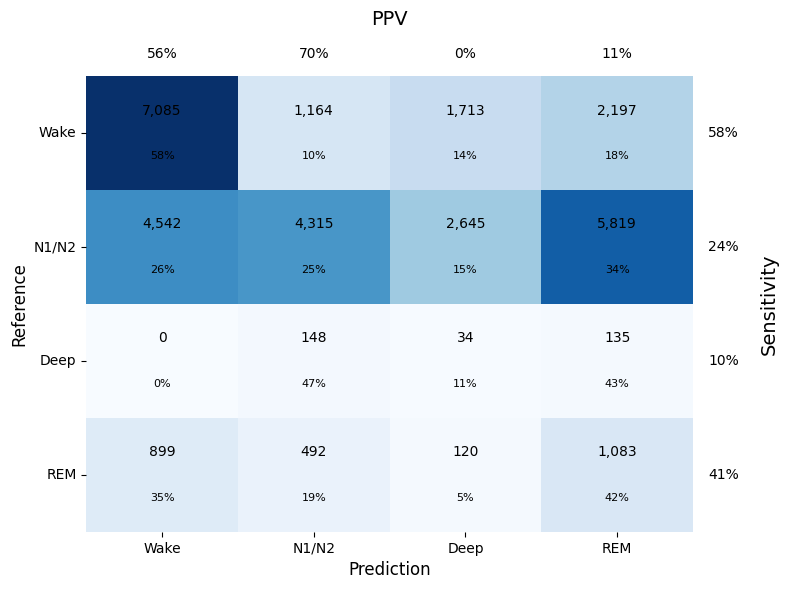

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model0.png
Done with loop 0


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:02<00:00, 47.31it/s, v_num=vh8z, train_loss_step=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 33.61it/s, v_num=vh8z, train_loss_step=1.280, val_loss=1.340, val_acc=0.307, val_cohen_kappa=0.0736, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.343


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 38.11it/s, v_num=vh8z, train_loss_step=1.340, val_loss=1.340, val_acc=0.307, val_cohen_kappa=0.0736, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 37.82it/s, v_num=vh8z, train_loss_step=1.250, val_loss=1.360, val_acc=0.217, val_cohen_kappa=0.0509, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:03<00:00, 29.38it/s, v_num=vh8z, train_loss_step=1.250, val_loss=1.310, val_acc=0.267, val_cohen_kappa=0.0875, train_loss_epoch=1.330]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.305


Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 37.21it/s, v_num=vh8z, train_loss_step=1.350, val_loss=1.310, val_acc=0.267, val_cohen_kappa=0.0875, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 37.78it/s, v_num=vh8z, train_loss_step=1.270, val_loss=1.310, val_acc=0.414, val_cohen_kappa=0.129, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 29.14it/s, v_num=vh8z, train_loss_step=1.270, val_loss=1.290, val_acc=0.229, val_cohen_kappa=0.0877, train_loss_epoch=1.260]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.291


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 37.67it/s, v_num=vh8z, train_loss_step=1.060, val_loss=1.290, val_acc=0.229, val_cohen_kappa=0.0877, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:03<00:00, 25.69it/s, v_num=vh8z, train_loss_step=1.060, val_loss=1.250, val_acc=0.328, val_cohen_kappa=0.142, train_loss_epoch=1.240] 

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.247


Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 23.64it/s, v_num=vh8z, train_loss_step=1.080, val_loss=1.250, val_acc=0.328, val_cohen_kappa=0.142, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 24.40it/s, v_num=vh8z, train_loss_step=1.000, val_loss=1.280, val_acc=0.351, val_cohen_kappa=0.135, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:05<00:00, 19.33it/s, v_num=vh8z, train_loss_step=1.000, val_loss=1.240, val_acc=0.487, val_cohen_kappa=0.185, train_loss_epoch=1.170]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.241


Epoch 8: 100%|██████████| 101/101 [00:04<00:00, 23.11it/s, v_num=vh8z, train_loss_step=1.180, val_loss=1.240, val_acc=0.487, val_cohen_kappa=0.185, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:04<00:00, 23.95it/s, v_num=vh8z, train_loss_step=1.060, val_loss=1.300, val_acc=0.395, val_cohen_kappa=0.136, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:04<00:00, 23.02it/s, v_num=vh8z, train_loss_step=1.460, val_loss=1.290, val_acc=0.397, val_cohen_kappa=0.177, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:04<00:00, 24.21it/s, v_num=vh8z, train_loss_step=0.745, val_loss=1.280, val_acc=0.397, val_cohen_kappa=0.149, train_loss_epoch=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:05<00:00, 17.87it/s, v_num=vh8z, train_loss_step=0.745, val_loss=1.210, val_acc=0.446, 

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.209


Epoch 12: 100%|██████████| 101/101 [00:04<00:00, 23.53it/s, v_num=vh8z, train_loss_step=1.040, val_loss=1.210, val_acc=0.446, val_cohen_kappa=0.207, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 26.27it/s, v_num=vh8z, train_loss_step=0.941, val_loss=1.300, val_acc=0.447, val_cohen_kappa=0.208, train_loss_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:04<00:00, 23.22it/s, v_num=vh8z, train_loss_step=0.736, val_loss=1.560, val_acc=0.441, val_cohen_kappa=0.170, train_loss_epoch=0.845]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:04<00:00, 23.11it/s, v_num=vh8z, train_loss_step=0.716, val_loss=1.540, val_acc=0.441, val_cohen_kappa=0.173, train_loss_epoch=0.756]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:05<00:00, 18.13it/s, v_num=vh8z, train_loss_step=0.716, val_loss=1.590, val_acc=0.514

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.209. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 101/101 [00:05<00:00, 18.11it/s, v_num=vh8z, train_loss_step=0.716, val_loss=1.590, val_acc=0.514, val_cohen_kappa=0.213, train_loss_epoch=0.702]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss_epoch,██▇▇▇▇▆▆▆▅▅▄▃▂▂▁
train_loss_step,▆▆▅▆▆▆█▇▆▆▅▅▇█▅▆▅▆▆▅▆▄▃▄▆▅▃▅▄▆▄▄▄▄▄▄▃▁▄▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█
val_acc,▃▁▂▆▁▄▄▇▅▅▅▆▆▆▆█
val_cohen_kappa,▂▁▃▄▃▅▅▇▅▆▅██▆▆█
val_loss,▃▄▃▃▂▂▂▂▃▃▂▁▃▇▇█
epoch,15
train_loss_epoch,0.70243
train_loss_step,0.71559
trainer/global_step,1615


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v34.ckpt
Trained model 1 in 76.81148028373718 seconds


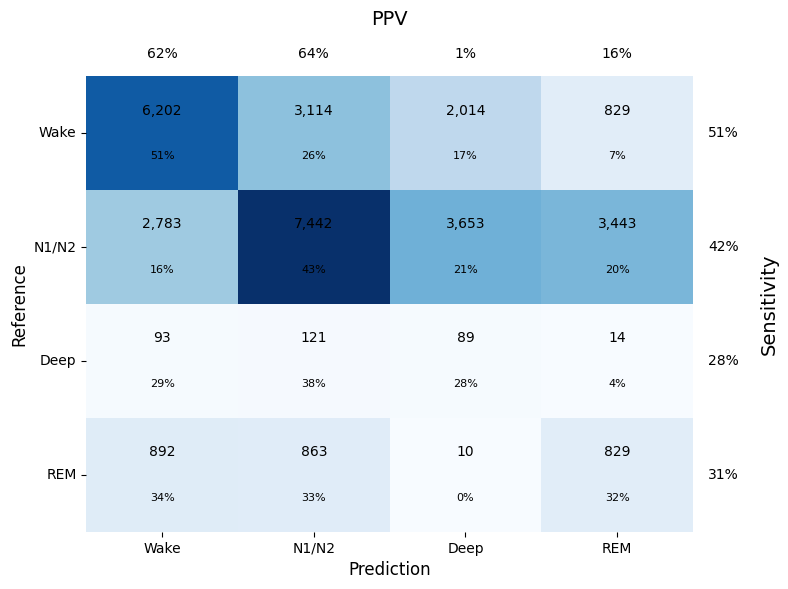

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model1.png
Done with loop 1


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 28.88it/s, v_num=9ftm, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:04<00:00, 21.66it/s, v_num=9ftm, train_loss_step=1.390, val_loss=1.330, val_acc=0.431, val_cohen_kappa=0.129, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.328


Epoch 1: 100%|██████████| 101/101 [00:03<00:00, 26.45it/s, v_num=9ftm, train_loss_step=1.340, val_loss=1.330, val_acc=0.431, val_cohen_kappa=0.129, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:05<00:00, 19.46it/s, v_num=9ftm, train_loss_step=1.340, val_loss=1.320, val_acc=0.306, val_cohen_kappa=0.050, train_loss_epoch=1.340]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.321


Epoch 2: 100%|██████████| 101/101 [00:04<00:00, 24.97it/s, v_num=9ftm, train_loss_step=1.560, val_loss=1.320, val_acc=0.306, val_cohen_kappa=0.050, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 23.62it/s, v_num=9ftm, train_loss_step=1.300, val_loss=1.320, val_acc=0.326, val_cohen_kappa=0.0831, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:05<00:00, 18.66it/s, v_num=9ftm, train_loss_step=1.300, val_loss=1.310, val_acc=0.469, val_cohen_kappa=0.128, train_loss_epoch=1.280] 

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.310


Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 29.83it/s, v_num=9ftm, train_loss_step=1.060, val_loss=1.310, val_acc=0.469, val_cohen_kappa=0.128, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 22.29it/s, v_num=9ftm, train_loss_step=1.060, val_loss=1.290, val_acc=0.458, val_cohen_kappa=0.151, train_loss_epoch=1.260]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.291


Epoch 5: 100%|██████████| 101/101 [00:04<00:00, 23.95it/s, v_num=9ftm, train_loss_step=1.250, val_loss=1.290, val_acc=0.458, val_cohen_kappa=0.151, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:04<00:00, 22.14it/s, v_num=9ftm, train_loss_step=1.010, val_loss=1.320, val_acc=0.340, val_cohen_kappa=0.126, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:05<00:00, 17.64it/s, v_num=9ftm, train_loss_step=1.010, val_loss=1.200, val_acc=0.385, val_cohen_kappa=0.152, train_loss_epoch=1.210]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 1.204


Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 23.51it/s, v_num=9ftm, train_loss_step=1.420, val_loss=1.200, val_acc=0.385, val_cohen_kappa=0.152, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:04<00:00, 22.04it/s, v_num=9ftm, train_loss_step=1.080, val_loss=1.280, val_acc=0.391, val_cohen_kappa=0.156, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:06<00:00, 16.03it/s, v_num=9ftm, train_loss_step=1.080, val_loss=1.190, val_acc=0.436, val_cohen_kappa=0.203, train_loss_epoch=1.100]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.195


Epoch 9: 100%|██████████| 101/101 [00:05<00:00, 17.85it/s, v_num=9ftm, train_loss_step=0.865, val_loss=1.190, val_acc=0.436, val_cohen_kappa=0.203, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 13.47it/s, v_num=9ftm, train_loss_step=0.865, val_loss=1.180, val_acc=0.455, val_cohen_kappa=0.216, train_loss_epoch=1.070]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.180


Epoch 10: 100%|██████████| 101/101 [00:06<00:00, 16.36it/s, v_num=9ftm, train_loss_step=0.966, val_loss=1.180, val_acc=0.455, val_cohen_kappa=0.216, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:06<00:00, 15.40it/s, v_num=9ftm, train_loss_step=1.660, val_loss=1.290, val_acc=0.359, val_cohen_kappa=0.142, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:05<00:00, 16.86it/s, v_num=9ftm, train_loss_step=0.723, val_loss=1.420, val_acc=0.444, val_cohen_kappa=0.164, train_loss_epoch=0.965]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:06<00:00, 15.49it/s, v_num=9ftm, train_loss_step=0.678, val_loss=1.270, val_acc=0.452, val_cohen_kappa=0.180, train_loss_epoch=0.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:08<00:00, 11.86it/s, v_num=9ftm, train_loss_step=0.678, val_loss=1.610, val_acc=0.463

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.180. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 101/101 [00:08<00:00, 11.83it/s, v_num=9ftm, train_loss_step=0.678, val_loss=1.610, val_acc=0.463, val_cohen_kappa=0.169, train_loss_epoch=0.740]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█
train_loss_epoch,██▇▇▇▆▆▆▅▅▄▃▂▁
train_loss_step,█▆▆▇▆▇▆▆▄▇▆█▅▇█▇▆▆▅▄▄▅▄▄▃▃▆▅▇▅▃▃▆▇▁█▃▃▄▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
val_acc,▆▁▂██▂▄▅▇▇▃▇▇█
val_cohen_kappa,▄▁▂▄▅▄▅▅▇█▅▆▆▆
val_loss,▃▃▃▃▃▃▁▃▁▁▃▅▂█
epoch,13
train_loss_epoch,0.74003
train_loss_step,0.67769
trainer/global_step,1413


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v35.ckpt
Trained model 2 in 89.98405265808105 seconds


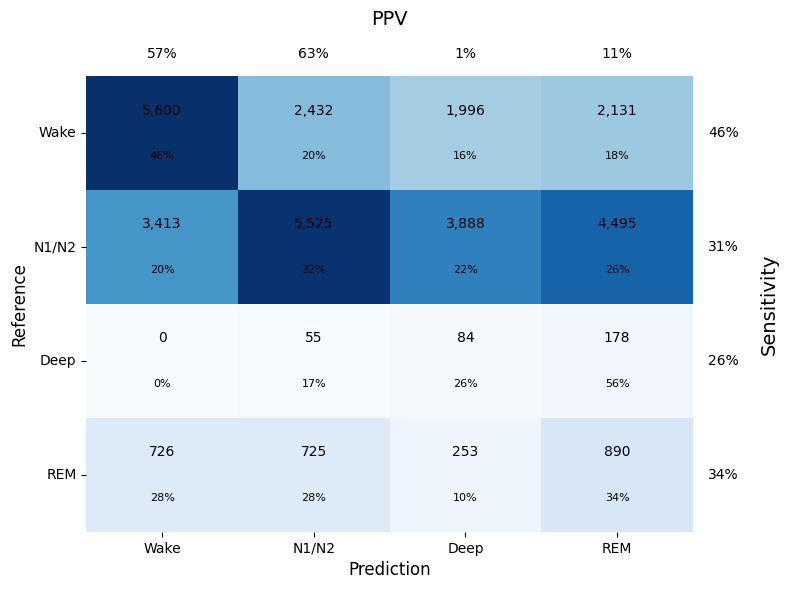

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model2.png
Done with loop 2


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 14.84it/s, v_num=wnv5, train_loss_step=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.53it/s, v_num=wnv5, train_loss_step=1.190, val_loss=1.370, val_acc=0.415, val_cohen_kappa=0.104, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.366


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.28it/s, v_num=wnv5, train_loss_step=1.340, val_loss=1.370, val_acc=0.415, val_cohen_kappa=0.104, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.69it/s, v_num=wnv5, train_loss_step=1.340, val_loss=1.310, val_acc=0.343, val_cohen_kappa=0.116, train_loss_epoch=1.320]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 1.310


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 12.94it/s, v_num=wnv5, train_loss_step=1.230, val_loss=1.310, val_acc=0.343, val_cohen_kappa=0.116, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:10<00:00,  9.85it/s, v_num=wnv5, train_loss_step=1.230, val_loss=1.300, val_acc=0.450, val_cohen_kappa=0.154, train_loss_epoch=1.300]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.301


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.29it/s, v_num=wnv5, train_loss_step=1.260, val_loss=1.300, val_acc=0.450, val_cohen_kappa=0.154, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.41it/s, v_num=wnv5, train_loss_step=1.260, val_loss=1.260, val_acc=0.359, val_cohen_kappa=0.132, train_loss_epoch=1.280]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.256


Epoch 4: 100%|██████████| 101/101 [00:08<00:00, 12.62it/s, v_num=wnv5, train_loss_step=1.150, val_loss=1.260, val_acc=0.359, val_cohen_kappa=0.132, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:10<00:00, 10.03it/s, v_num=wnv5, train_loss_step=1.150, val_loss=1.220, val_acc=0.349, val_cohen_kappa=0.160, train_loss_epoch=1.270]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.216


Epoch 5: 100%|██████████| 101/101 [00:08<00:00, 12.52it/s, v_num=wnv5, train_loss_step=1.430, val_loss=1.220, val_acc=0.349, val_cohen_kappa=0.160, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:07<00:00, 14.04it/s, v_num=wnv5, train_loss_step=1.280, val_loss=1.290, val_acc=0.371, val_cohen_kappa=0.123, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:08<00:00, 12.38it/s, v_num=wnv5, train_loss_step=1.110, val_loss=1.290, val_acc=0.313, val_cohen_kappa=0.104, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:08<00:00, 12.37it/s, v_num=wnv5, train_loss_step=1.100, val_loss=1.260, val_acc=0.362, val_cohen_kappa=0.161, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:10<00:00, 10.09it/s, v_num=wnv5, train_loss_step=1.100, val_loss=1.190, val_acc=0.387, val

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.192


Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 13.48it/s, v_num=wnv5, train_loss_step=1.190, val_loss=1.190, val_acc=0.387, val_cohen_kappa=0.171, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:07<00:00, 14.25it/s, v_num=wnv5, train_loss_step=0.996, val_loss=1.200, val_acc=0.342, val_cohen_kappa=0.176, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:07<00:00, 13.02it/s, v_num=wnv5, train_loss_step=0.999, val_loss=1.210, val_acc=0.359, val_cohen_kappa=0.172, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:07<00:00, 13.09it/s, v_num=wnv5, train_loss_step=0.964, val_loss=1.310, val_acc=0.379, val_cohen_kappa=0.139, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 10.49it/s, v_num=wnv5, train_loss_step=0.964, val_loss=1.370, val_acc=0.433,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.192. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 10.48it/s, v_num=wnv5, train_loss_step=0.964, val_loss=1.370, val_acc=0.433, val_cohen_kappa=0.144, train_loss_epoch=0.957]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▇▆▆▆▅▅▄▄▃▂▁
train_loss_step,▄▅▆▆▅▃▃▇▃▅█▇▄▄▄▆▂▃▅▁▃▄▁▅▂▃▃▄▂▂▃▂▅▁▂▂▁▁▂▄
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
val_acc,▆▃█▃▃▄▁▄▅▃▃▄▇
val_cohen_kappa,▁▂▆▄▆▃▁▇███▄▅
val_loss,█▆▅▃▂▅▅▃▁▁▂▆█
epoch,12
train_loss_epoch,0.95663
train_loss_step,0.96424
trainer/global_step,1312


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v36.ckpt
Trained model 3 in 129.6158323287964 seconds


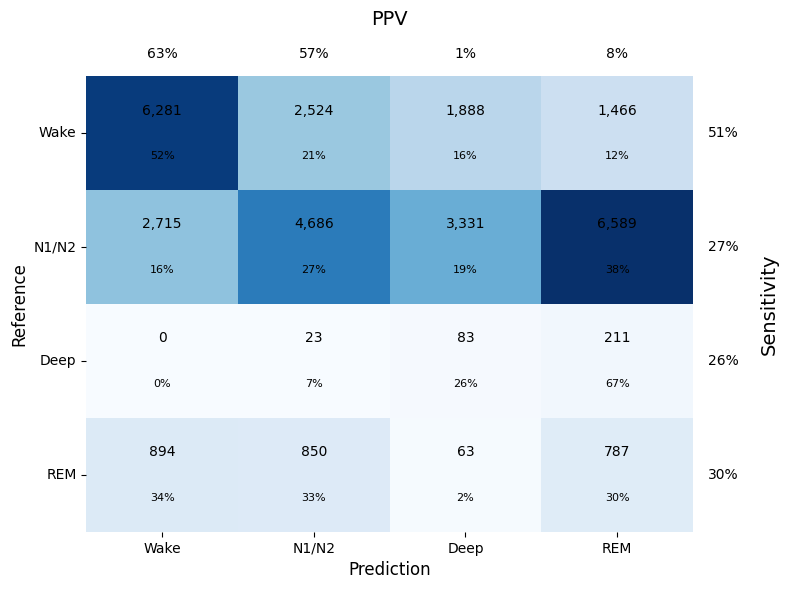

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model3.png
Done with loop 3


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:07<00:00, 14.22it/s, v_num=7qcd, train_loss_step=1.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.57it/s, v_num=7qcd, train_loss_step=1.440, val_loss=1.390, val_acc=0.367, val_cohen_kappa=0.101, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.389


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 12.98it/s, v_num=7qcd, train_loss_step=1.310, val_loss=1.390, val_acc=0.367, val_cohen_kappa=0.101, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:10<00:00, 10.02it/s, v_num=7qcd, train_loss_step=1.310, val_loss=1.360, val_acc=0.415, val_cohen_kappa=0.145, train_loss_epoch=1.330]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.358


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 12.79it/s, v_num=7qcd, train_loss_step=1.430, val_loss=1.360, val_acc=0.415, val_cohen_kappa=0.145, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:10<00:00,  9.95it/s, v_num=7qcd, train_loss_step=1.430, val_loss=1.320, val_acc=0.339, val_cohen_kappa=0.103, train_loss_epoch=1.310]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.316


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 12.74it/s, v_num=7qcd, train_loss_step=0.960, val_loss=1.320, val_acc=0.339, val_cohen_kappa=0.103, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:10<00:00,  9.91it/s, v_num=7qcd, train_loss_step=0.960, val_loss=1.290, val_acc=0.279, val_cohen_kappa=0.097, train_loss_epoch=1.280]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.287


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 12.64it/s, v_num=7qcd, train_loss_step=1.790, val_loss=1.290, val_acc=0.279, val_cohen_kappa=0.097, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:09<00:00, 10.21it/s, v_num=7qcd, train_loss_step=1.790, val_loss=1.250, val_acc=0.233, val_cohen_kappa=0.099, train_loss_epoch=1.260]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.254


Epoch 5: 100%|██████████| 101/101 [00:08<00:00, 12.46it/s, v_num=7qcd, train_loss_step=1.210, val_loss=1.250, val_acc=0.233, val_cohen_kappa=0.099, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:10<00:00,  9.99it/s, v_num=7qcd, train_loss_step=1.210, val_loss=1.200, val_acc=0.308, val_cohen_kappa=0.164, train_loss_epoch=1.230]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.204


Epoch 6: 100%|██████████| 101/101 [00:07<00:00, 13.58it/s, v_num=7qcd, train_loss_step=0.964, val_loss=1.200, val_acc=0.308, val_cohen_kappa=0.164, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:09<00:00, 10.95it/s, v_num=7qcd, train_loss_step=0.964, val_loss=1.200, val_acc=0.417, val_cohen_kappa=0.176, train_loss_epoch=1.210]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.201


Epoch 7: 100%|██████████| 101/101 [00:07<00:00, 13.52it/s, v_num=7qcd, train_loss_step=1.360, val_loss=1.200, val_acc=0.417, val_cohen_kappa=0.176, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:07<00:00, 14.18it/s, v_num=7qcd, train_loss_step=1.350, val_loss=1.220, val_acc=0.501, val_cohen_kappa=0.227, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:08<00:00, 11.41it/s, v_num=7qcd, train_loss_step=1.350, val_loss=1.180, val_acc=0.305, val_cohen_kappa=0.163, train_loss_epoch=1.140]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.178


Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 12.73it/s, v_num=7qcd, train_loss_step=1.160, val_loss=1.180, val_acc=0.305, val_cohen_kappa=0.163, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:10<00:00,  9.98it/s, v_num=7qcd, train_loss_step=1.160, val_loss=1.120, val_acc=0.440, val_cohen_kappa=0.233, train_loss_epoch=1.100]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.115


Epoch 10: 100%|██████████| 101/101 [00:07<00:00, 13.49it/s, v_num=7qcd, train_loss_step=0.900, val_loss=1.120, val_acc=0.440, val_cohen_kappa=0.233, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:07<00:00, 13.33it/s, v_num=7qcd, train_loss_step=1.130, val_loss=1.170, val_acc=0.481, val_cohen_kappa=0.246, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:07<00:00, 13.44it/s, v_num=7qcd, train_loss_step=1.090, val_loss=1.280, val_acc=0.467, val_cohen_kappa=0.205, train_loss_epoch=0.984]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:07<00:00, 12.74it/s, v_num=7qcd, train_loss_step=0.480, val_loss=1.170, val_acc=0.504, val_cohen_kappa=0.249, train_loss_epoch=0.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:09<00:00, 10.10it/s, v_num=7qcd, train_loss_step=0.480, val_loss=1.340, val_acc=0.457

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.115. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 101/101 [00:10<00:00, 10.08it/s, v_num=7qcd, train_loss_step=0.480, val_loss=1.340, val_acc=0.457, val_cohen_kappa=0.211, train_loss_epoch=0.821]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
train_loss_epoch,█▇▇▇▇▆▆▆▅▅▄▃▂▁
train_loss_step,▆▆▆▅▇█▆▅▇▄▆▆▇▅▄▇▅▅▅▃▄▆▄▅▂▅▆▃▃▄▂▃▄▃▁▂▃▁▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▄▆▄▂▁▃▆█▃▆▇▇█▇
val_cohen_kappa,▁▃▁▁▁▄▅▇▄▇█▆█▆
val_loss,█▇▆▅▅▃▃▄▃▁▂▅▂▇
epoch,13
train_loss_epoch,0.82093
train_loss_step,0.47983
trainer/global_step,1413


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v37.ckpt
Trained model 4 in 138.01384353637695 seconds


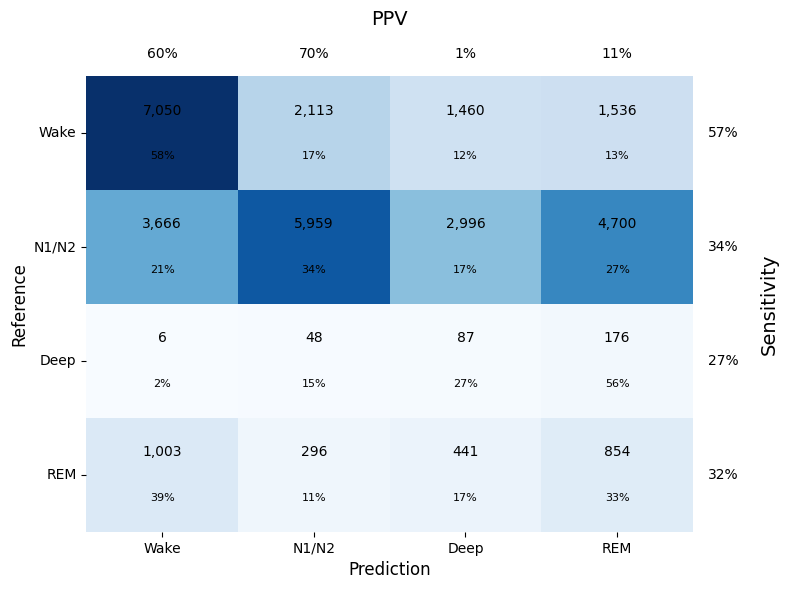

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model4.png
Done with loop 4


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 14.45it/s, v_num=6ec3, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:09<00:00, 11.18it/s, v_num=6ec3, train_loss_step=1.310, val_loss=1.380, val_acc=0.468, val_cohen_kappa=0.131, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.378


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 14.42it/s, v_num=6ec3, train_loss_step=1.480, val_loss=1.380, val_acc=0.468, val_cohen_kappa=0.131, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.81it/s, v_num=6ec3, train_loss_step=1.480, val_loss=1.340, val_acc=0.303, val_cohen_kappa=0.0784, train_loss_epoch=1.340]

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.338


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 12.70it/s, v_num=6ec3, train_loss_step=1.350, val_loss=1.340, val_acc=0.303, val_cohen_kappa=0.0784, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.61it/s, v_num=6ec3, train_loss_step=1.110, val_loss=1.370, val_acc=0.362, val_cohen_kappa=0.104, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.78it/s, v_num=6ec3, train_loss_step=1.110, val_loss=1.330, val_acc=0.230, val_cohen_kappa=0.0844, train_loss_epoch=1.280]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.329


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 12.90it/s, v_num=6ec3, train_loss_step=1.170, val_loss=1.330, val_acc=0.230, val_cohen_kappa=0.0844, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:10<00:00,  9.93it/s, v_num=6ec3, train_loss_step=1.170, val_loss=1.260, val_acc=0.270, val_cohen_kappa=0.120, train_loss_epoch=1.260] 

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.257


Epoch 5: 100%|██████████| 101/101 [00:07<00:00, 12.69it/s, v_num=6ec3, train_loss_step=1.190, val_loss=1.260, val_acc=0.270, val_cohen_kappa=0.120, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:08<00:00, 12.38it/s, v_num=6ec3, train_loss_step=1.240, val_loss=1.260, val_acc=0.371, val_cohen_kappa=0.146, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:08<00:00, 12.52it/s, v_num=6ec3, train_loss_step=0.967, val_loss=1.270, val_acc=0.492, val_cohen_kappa=0.204, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:10<00:00,  9.81it/s, v_num=6ec3, train_loss_step=0.967, val_loss=1.180, val_acc=0.448, val_cohen_kappa=0.218, train_loss_epoch=1.170]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 1.177


Epoch 8: 100%|██████████| 101/101 [00:08<00:00, 11.58it/s, v_num=6ec3, train_loss_step=0.911, val_loss=1.180, val_acc=0.448, val_cohen_kappa=0.218, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:10<00:00,  9.32it/s, v_num=6ec3, train_loss_step=0.911, val_loss=1.130, val_acc=0.339, val_cohen_kappa=0.172, train_loss_epoch=1.110]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.133


Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 13.12it/s, v_num=6ec3, train_loss_step=0.924, val_loss=1.130, val_acc=0.339, val_cohen_kappa=0.172, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:08<00:00, 12.07it/s, v_num=6ec3, train_loss_step=0.941, val_loss=1.310, val_acc=0.459, val_cohen_kappa=0.207, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:07<00:00, 13.04it/s, v_num=6ec3, train_loss_step=0.541, val_loss=1.420, val_acc=0.415, val_cohen_kappa=0.182, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:07<00:00, 12.66it/s, v_num=6ec3, train_loss_step=1.060, val_loss=1.270, val_acc=0.398, val_cohen_kappa=0.185, train_loss_epoch=0.957]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:10<00:00,  9.95it/s, v_num=6ec3, train_loss_step=1.060, val_loss=1.430, val_acc=0.545,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.133. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:10<00:00,  9.93it/s, v_num=6ec3, train_loss_step=1.060, val_loss=1.430, val_acc=0.545, val_cohen_kappa=0.231, train_loss_epoch=0.897]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss_epoch,█▇▇▇▆▆▆▅▄▄▃▂▁
train_loss_step,▅▆█▅▇▆▇▇▄▄▅█▅▇▄▆▅▄▃▄█▁▄▄▃▃▁▃▆▂▇▃▄▂▄▂▂▂▄▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
val_acc,▆▃▄▁▂▄▇▆▃▆▅▅█
val_cohen_kappa,▃▁▂▁▃▄▇▇▅▇▆▆█
val_loss,▇▆▇▆▄▄▄▂▁▅█▄█
epoch,12
train_loss_epoch,0.89689
train_loss_step,1.0606
trainer/global_step,1312


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v38.ckpt
Trained model 5 in 133.8340620994568 seconds


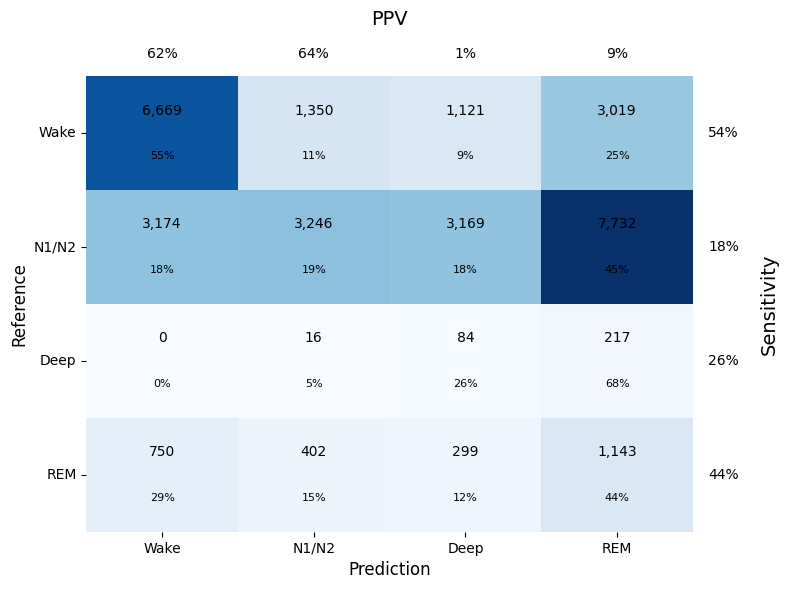

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model5.png
Done with loop 5


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:07<00:00, 14.41it/s, v_num=wumo, train_loss_step=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.23it/s, v_num=wumo, train_loss_step=1.340, val_loss=1.360, val_acc=0.324, val_cohen_kappa=0.109, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.358


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.17it/s, v_num=wumo, train_loss_step=1.140, val_loss=1.360, val_acc=0.324, val_cohen_kappa=0.109, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.45it/s, v_num=wumo, train_loss_step=1.140, val_loss=1.340, val_acc=0.249, val_cohen_kappa=0.053, train_loss_epoch=1.350]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.339


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 13.51it/s, v_num=wumo, train_loss_step=1.230, val_loss=1.340, val_acc=0.249, val_cohen_kappa=0.053, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:09<00:00, 10.52it/s, v_num=wumo, train_loss_step=1.230, val_loss=1.300, val_acc=0.362, val_cohen_kappa=0.131, train_loss_epoch=1.310]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.305


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.13it/s, v_num=wumo, train_loss_step=1.440, val_loss=1.300, val_acc=0.362, val_cohen_kappa=0.131, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.44it/s, v_num=wumo, train_loss_step=1.440, val_loss=1.290, val_acc=0.328, val_cohen_kappa=0.126, train_loss_epoch=1.290]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.295


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 13.14it/s, v_num=wumo, train_loss_step=1.460, val_loss=1.290, val_acc=0.328, val_cohen_kappa=0.126, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:06<00:00, 14.56it/s, v_num=wumo, train_loss_step=1.190, val_loss=1.300, val_acc=0.270, val_cohen_kappa=0.0868, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:08<00:00, 11.58it/s, v_num=wumo, train_loss_step=1.190, val_loss=1.280, val_acc=0.308, val_cohen_kappa=0.119, train_loss_epoch=1.260] 

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.280


Epoch 6: 100%|██████████| 101/101 [00:07<00:00, 13.63it/s, v_num=wumo, train_loss_step=1.100, val_loss=1.280, val_acc=0.308, val_cohen_kappa=0.119, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:09<00:00, 10.42it/s, v_num=wumo, train_loss_step=1.100, val_loss=1.250, val_acc=0.298, val_cohen_kappa=0.111, train_loss_epoch=1.230]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.252


Epoch 7: 100%|██████████| 101/101 [00:07<00:00, 13.20it/s, v_num=wumo, train_loss_step=1.020, val_loss=1.250, val_acc=0.298, val_cohen_kappa=0.111, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:09<00:00, 10.32it/s, v_num=wumo, train_loss_step=1.020, val_loss=1.170, val_acc=0.354, val_cohen_kappa=0.174, train_loss_epoch=1.190]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.173


Epoch 8: 100%|██████████| 101/101 [00:08<00:00, 12.44it/s, v_num=wumo, train_loss_step=1.020, val_loss=1.170, val_acc=0.354, val_cohen_kappa=0.174, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:10<00:00,  9.96it/s, v_num=wumo, train_loss_step=1.020, val_loss=1.130, val_acc=0.367, val_cohen_kappa=0.183, train_loss_epoch=1.140]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.132


Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 12.68it/s, v_num=wumo, train_loss_step=1.430, val_loss=1.130, val_acc=0.367, val_cohen_kappa=0.183, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:08<00:00, 12.49it/s, v_num=wumo, train_loss_step=0.896, val_loss=1.150, val_acc=0.415, val_cohen_kappa=0.207, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:07<00:00, 14.11it/s, v_num=wumo, train_loss_step=1.100, val_loss=1.250, val_acc=0.434, val_cohen_kappa=0.210, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:07<00:00, 14.03it/s, v_num=wumo, train_loss_step=0.842, val_loss=1.230, val_acc=0.409, val_cohen_kappa=0.174, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 11.18it/s, v_num=wumo, train_loss_step=0.842, val_loss=1.210, val_acc=0.440,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.132. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 11.17it/s, v_num=wumo, train_loss_step=0.842, val_loss=1.210, val_acc=0.440, val_cohen_kappa=0.210, train_loss_epoch=0.908]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
train_loss_epoch,█▇▇▇▆▆▆▅▄▄▃▃▁
train_loss_step,▅▅▄▄▅▄▄▅▅▄▅▅▅▅▄▅▃▆▅▆▄█▆▄▄▃▃▂▄▄▁▄▅▂▄▃▃▂▁▅
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▄▁▅▄▂▃▃▅▅▇█▇█
val_cohen_kappa,▃▁▄▄▃▄▄▆▇██▆█
val_loss,█▇▆▆▆▆▅▂▁▂▅▄▃
epoch,12
train_loss_epoch,0.90808
train_loss_step,0.84218
trainer/global_step,1312


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v39.ckpt
Trained model 6 in 127.61775255203247 seconds


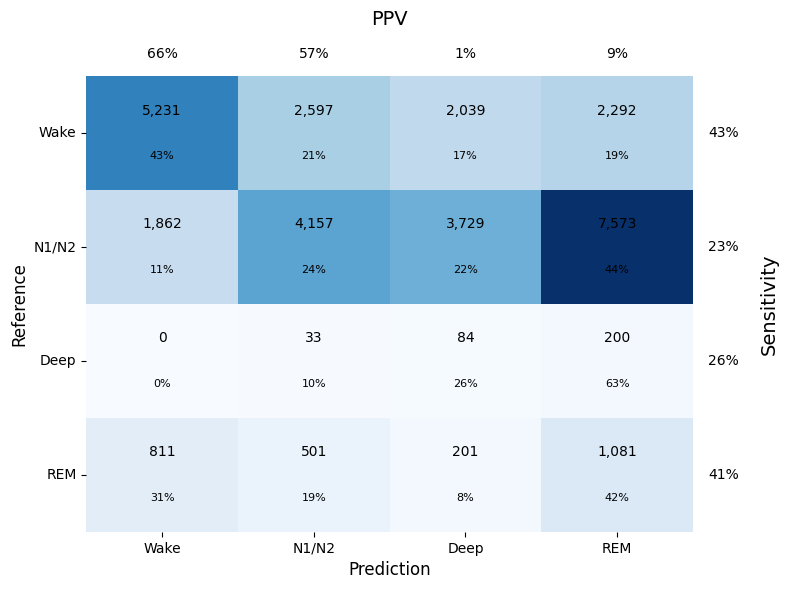

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model6.png
Done with loop 6


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:07<00:00, 14.24it/s, v_num=deyd, train_loss_step=1.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.44it/s, v_num=deyd, train_loss_step=1.430, val_loss=1.360, val_acc=0.238, val_cohen_kappa=0.0395, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.357


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.47it/s, v_num=deyd, train_loss_step=1.340, val_loss=1.360, val_acc=0.238, val_cohen_kappa=0.0395, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.32it/s, v_num=deyd, train_loss_step=1.340, val_loss=1.320, val_acc=0.342, val_cohen_kappa=0.0916, train_loss_epoch=1.320]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.316


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 12.93it/s, v_num=deyd, train_loss_step=1.270, val_loss=1.320, val_acc=0.342, val_cohen_kappa=0.0916, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:09<00:00, 10.23it/s, v_num=deyd, train_loss_step=1.270, val_loss=1.300, val_acc=0.344, val_cohen_kappa=0.110, train_loss_epoch=1.300] 

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.299


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.12it/s, v_num=deyd, train_loss_step=1.640, val_loss=1.300, val_acc=0.344, val_cohen_kappa=0.110, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.50it/s, v_num=deyd, train_loss_step=1.640, val_loss=1.300, val_acc=0.442, val_cohen_kappa=0.166, train_loss_epoch=1.280]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.297


Epoch 4: 100%|██████████| 101/101 [00:08<00:00, 12.46it/s, v_num=deyd, train_loss_step=1.140, val_loss=1.300, val_acc=0.442, val_cohen_kappa=0.166, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:09<00:00, 10.63it/s, v_num=deyd, train_loss_step=1.140, val_loss=1.250, val_acc=0.296, val_cohen_kappa=0.114, train_loss_epoch=1.260]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.248


Epoch 5: 100%|██████████| 101/101 [00:07<00:00, 14.08it/s, v_num=deyd, train_loss_step=1.310, val_loss=1.250, val_acc=0.296, val_cohen_kappa=0.114, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:07<00:00, 13.45it/s, v_num=deyd, train_loss_step=1.220, val_loss=1.320, val_acc=0.589, val_cohen_kappa=0.211, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:08<00:00, 11.97it/s, v_num=deyd, train_loss_step=0.971, val_loss=1.250, val_acc=0.447, val_cohen_kappa=0.152, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:10<00:00,  9.43it/s, v_num=deyd, train_loss_step=0.971, val_loss=1.210, val_acc=0.414, val_cohen_kappa=0.160, train_loss_epoch=1.180]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.213


Epoch 8: 100%|██████████| 101/101 [00:07<00:00, 12.95it/s, v_num=deyd, train_loss_step=1.160, val_loss=1.210, val_acc=0.414, val_cohen_kappa=0.160, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:09<00:00, 10.32it/s, v_num=deyd, train_loss_step=1.160, val_loss=1.210, val_acc=0.400, val_cohen_kappa=0.171, train_loss_epoch=1.140]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.211


Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 13.69it/s, v_num=deyd, train_loss_step=0.823, val_loss=1.210, val_acc=0.400, val_cohen_kappa=0.171, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:08<00:00, 12.44it/s, v_num=deyd, train_loss_step=1.330, val_loss=1.250, val_acc=0.384, val_cohen_kappa=0.181, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:08<00:00, 12.27it/s, v_num=deyd, train_loss_step=1.210, val_loss=1.240, val_acc=0.437, val_cohen_kappa=0.182, train_loss_epoch=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:07<00:00, 13.22it/s, v_num=deyd, train_loss_step=1.160, val_loss=1.260, val_acc=0.399, val_cohen_kappa=0.179, train_loss_epoch=1.010]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 10.39it/s, v_num=deyd, train_loss_step=1.160, val_loss=1.480, val_acc=0.449,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.211. Signaling Trainer to stop.


Epoch 12: 100%|██████████| 101/101 [00:09<00:00, 10.37it/s, v_num=deyd, train_loss_step=1.160, val_loss=1.480, val_acc=0.449, val_cohen_kappa=0.180, train_loss_epoch=0.916]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
train_loss_epoch,█▇▇▇▆▆▅▅▄▄▃▂▁
train_loss_step,▇▅▆▆▅▆▅▅▇▆▆▆▅▅█▅▃▆▅▄▃▅▆▄▃▄▅▅▂▅▁▅▃▆▃▃▃▂▁▂
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▃▃▅▂█▅▅▄▄▅▄▅
val_cohen_kappa,▁▃▄▆▄█▆▆▆▇▇▇▇
val_loss,▅▄▃▃▂▄▂▁▁▂▂▂█
epoch,12
train_loss_epoch,0.9162
train_loss_step,1.15944
trainer/global_step,1312


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v40.ckpt
Trained model 7 in 129.12832283973694 seconds


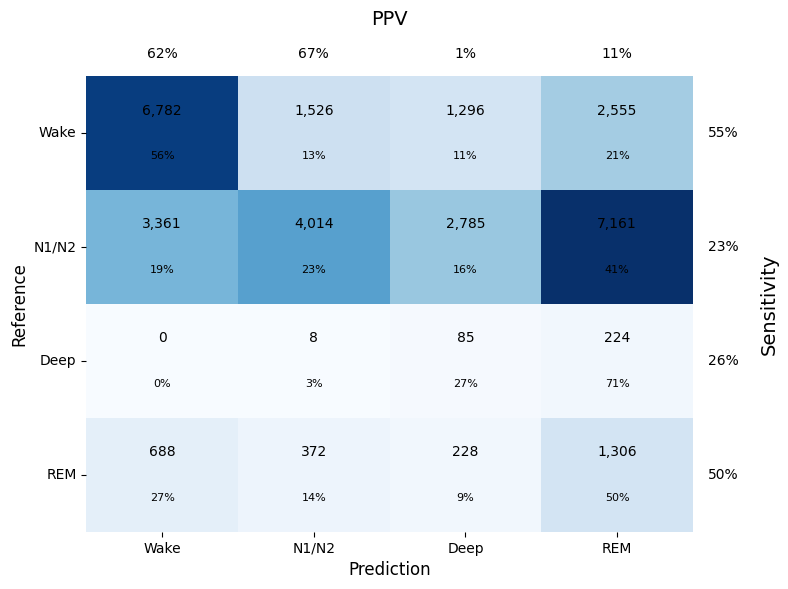

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model7.png
Done with loop 7


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 15.00it/s, v_num=jpyx, train_loss_step=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.35it/s, v_num=jpyx, train_loss_step=1.400, val_loss=1.390, val_acc=0.332, val_cohen_kappa=0.0657, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.391


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.06it/s, v_num=jpyx, train_loss_step=1.320, val_loss=1.390, val_acc=0.332, val_cohen_kappa=0.0657, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.29it/s, v_num=jpyx, train_loss_step=1.320, val_loss=1.360, val_acc=0.461, val_cohen_kappa=0.128, train_loss_epoch=1.350] 

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.365


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 13.11it/s, v_num=jpyx, train_loss_step=1.290, val_loss=1.360, val_acc=0.461, val_cohen_kappa=0.128, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 12.66it/s, v_num=jpyx, train_loss_step=1.340, val_loss=1.370, val_acc=0.414, val_cohen_kappa=0.0569, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:10<00:00,  9.95it/s, v_num=jpyx, train_loss_step=1.340, val_loss=1.300, val_acc=0.449, val_cohen_kappa=0.182, train_loss_epoch=1.300] 

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.295


Epoch 4: 100%|██████████| 101/101 [00:08<00:00, 12.15it/s, v_num=jpyx, train_loss_step=1.170, val_loss=1.300, val_acc=0.449, val_cohen_kappa=0.182, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:10<00:00,  9.63it/s, v_num=jpyx, train_loss_step=1.170, val_loss=1.190, val_acc=0.419, val_cohen_kappa=0.193, train_loss_epoch=1.270]

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 1.192


Epoch 5: 100%|██████████| 101/101 [00:07<00:00, 13.16it/s, v_num=jpyx, train_loss_step=0.906, val_loss=1.190, val_acc=0.419, val_cohen_kappa=0.193, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:09<00:00, 10.55it/s, v_num=jpyx, train_loss_step=0.906, val_loss=1.160, val_acc=0.302, val_cohen_kappa=0.155, train_loss_epoch=1.230]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.164


Epoch 6: 100%|██████████| 101/101 [00:07<00:00, 13.45it/s, v_num=jpyx, train_loss_step=0.821, val_loss=1.160, val_acc=0.302, val_cohen_kappa=0.155, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:08<00:00, 12.39it/s, v_num=jpyx, train_loss_step=1.300, val_loss=1.170, val_acc=0.411, val_cohen_kappa=0.180, train_loss_epoch=1.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:10<00:00,  9.83it/s, v_num=jpyx, train_loss_step=1.300, val_loss=1.110, val_acc=0.344, val_cohen_kappa=0.184, train_loss_epoch=1.160]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.107


Epoch 8: 100%|██████████| 101/101 [00:07<00:00, 12.78it/s, v_num=jpyx, train_loss_step=1.360, val_loss=1.110, val_acc=0.344, val_cohen_kappa=0.184, train_loss_epoch=1.160]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:08<00:00, 12.61it/s, v_num=jpyx, train_loss_step=1.430, val_loss=1.130, val_acc=0.402, val_cohen_kappa=0.213, train_loss_epoch=1.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:07<00:00, 12.73it/s, v_num=jpyx, train_loss_step=0.794, val_loss=1.120, val_acc=0.449, val_cohen_kappa=0.226, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:07<00:00, 13.07it/s, v_num=jpyx, train_loss_step=1.210, val_loss=1.170, val_acc=0.440, val_cohen_kappa=0.199, train_loss_epoch=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:09<00:00, 10.36it/s, v_num=jpyx, train_loss_step=1.210, val_loss=1.080, val_acc=0.433, 

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.078


Epoch 12: 100%|██████████| 101/101 [00:06<00:00, 15.22it/s, v_num=jpyx, train_loss_step=1.050, val_loss=1.080, val_acc=0.433, val_cohen_kappa=0.222, train_loss_epoch=0.989]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:07<00:00, 13.03it/s, v_num=jpyx, train_loss_step=0.644, val_loss=1.200, val_acc=0.513, val_cohen_kappa=0.209, train_loss_epoch=0.973]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:08<00:00, 12.60it/s, v_num=jpyx, train_loss_step=0.702, val_loss=1.390, val_acc=0.393, val_cohen_kappa=0.165, train_loss_epoch=0.875]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:07<00:00, 13.13it/s, v_num=jpyx, train_loss_step=0.493, val_loss=1.580, val_acc=0.510, val_cohen_kappa=0.197, train_loss_epoch=0.767]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:09<00:00, 10.32it/s, v_num=jpyx, train_loss_step=0.493, val_loss=1.390, val_acc=0.501

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.078. Signaling Trainer to stop.


Epoch 15: 100%|██████████| 101/101 [00:09<00:00, 10.30it/s, v_num=jpyx, train_loss_step=0.493, val_loss=1.390, val_acc=0.501, val_cohen_kappa=0.204, train_loss_epoch=0.695]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss_epoch,██▇▇▇▆▆▆▆▅▅▄▄▃▂▁
train_loss_step,▆▇▇▇▆▆▆▅▆▆██▆▇▅▇▅▆▆▅▅▄▆▆▅▆▆▇▄▃▄▅▂▅▃▄▄▄▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇████
val_acc,▂▆▅▆▅▁▅▂▄▆▆▅█▄██
val_cohen_kappa,▁▄▁▆▇▅▆▆▇█▇█▇▅▇▇
val_loss,▅▅▅▄▃▂▂▁▂▂▂▁▃▅█▅
epoch,15
train_loss_epoch,0.69509
train_loss_step,0.49273
trainer/global_step,1615


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v41.ckpt
Trained model 8 in 161.49460458755493 seconds


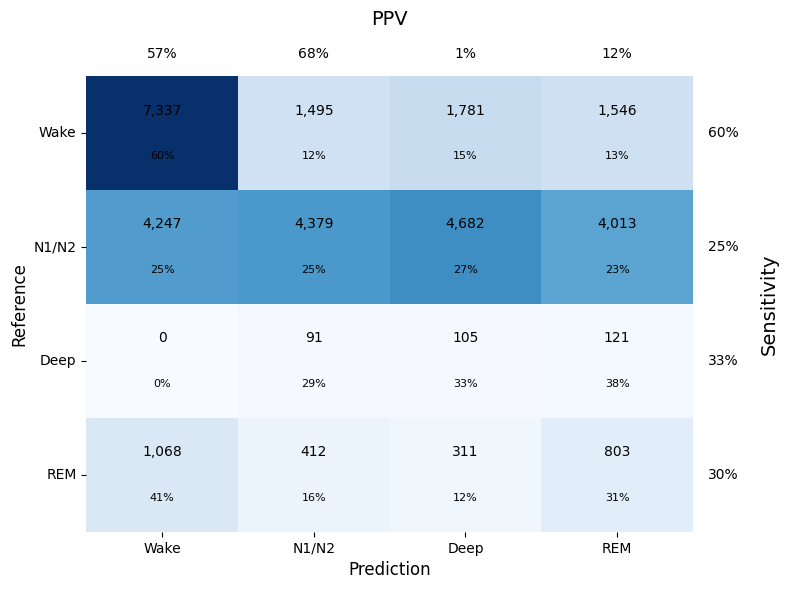

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model8.png
Done with loop 8


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | GRU                  | 427 K  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val

Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 14.59it/s, v_num=bnx5, train_loss_step=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:08<00:00, 11.58it/s, v_num=bnx5, train_loss_step=1.260, val_loss=1.330, val_acc=0.373, val_cohen_kappa=0.115, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.327


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.21it/s, v_num=bnx5, train_loss_step=1.220, val_loss=1.330, val_acc=0.373, val_cohen_kappa=0.115, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 10.48it/s, v_num=bnx5, train_loss_step=1.220, val_loss=1.320, val_acc=0.341, val_cohen_kappa=0.103, train_loss_epoch=1.330]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.315


Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 13.17it/s, v_num=bnx5, train_loss_step=1.130, val_loss=1.320, val_acc=0.341, val_cohen_kappa=0.103, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:09<00:00, 10.48it/s, v_num=bnx5, train_loss_step=1.130, val_loss=1.270, val_acc=0.353, val_cohen_kappa=0.131, train_loss_epoch=1.290]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.265


Epoch 3: 100%|██████████| 101/101 [00:08<00:00, 12.31it/s, v_num=bnx5, train_loss_step=1.200, val_loss=1.270, val_acc=0.353, val_cohen_kappa=0.131, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:09<00:00, 10.40it/s, v_num=bnx5, train_loss_step=1.200, val_loss=1.220, val_acc=0.391, val_cohen_kappa=0.168, train_loss_epoch=1.280]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.219


Epoch 4: 100%|██████████| 101/101 [00:07<00:00, 13.80it/s, v_num=bnx5, train_loss_step=1.310, val_loss=1.220, val_acc=0.391, val_cohen_kappa=0.168, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:07<00:00, 12.89it/s, v_num=bnx5, train_loss_step=1.270, val_loss=1.240, val_acc=0.390, val_cohen_kappa=0.158, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:09<00:00, 10.24it/s, v_num=bnx5, train_loss_step=1.270, val_loss=1.200, val_acc=0.335, val_cohen_kappa=0.160, train_loss_epoch=1.200]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.198


Epoch 6: 100%|██████████| 101/101 [00:08<00:00, 12.55it/s, v_num=bnx5, train_loss_step=0.942, val_loss=1.200, val_acc=0.335, val_cohen_kappa=0.160, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:10<00:00,  9.99it/s, v_num=bnx5, train_loss_step=0.942, val_loss=1.170, val_acc=0.378, val_cohen_kappa=0.192, train_loss_epoch=1.180]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.174


Epoch 7: 100%|██████████| 101/101 [00:07<00:00, 13.47it/s, v_num=bnx5, train_loss_step=1.460, val_loss=1.170, val_acc=0.378, val_cohen_kappa=0.192, train_loss_epoch=1.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:08<00:00, 12.56it/s, v_num=bnx5, train_loss_step=0.934, val_loss=1.230, val_acc=0.339, val_cohen_kappa=0.160, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:07<00:00, 13.25it/s, v_num=bnx5, train_loss_step=1.320, val_loss=1.210, val_acc=0.328, val_cohen_kappa=0.164, train_loss_epoch=1.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:07<00:00, 12.90it/s, v_num=bnx5, train_loss_step=1.090, val_loss=1.250, val_acc=0.508, val_cohen_kappa=0.222, train_loss_epoch=1.070]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:09<00:00, 10.39it/s, v_num=bnx5, train_loss_step=1.090, val_loss=1.240, val_acc=0.437, v

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.174. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 101/101 [00:09<00:00, 10.37it/s, v_num=bnx5, train_loss_step=1.090, val_loss=1.240, val_acc=0.437, val_cohen_kappa=0.205, train_loss_epoch=0.981]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▇▆▆▅▅▄▃▃▁
train_loss_step,▆▇▆▇█▇▆▇▄▄▅▄▃▇▃▃▄▄▅█▄▅▃▂▃▂▅▂▃▆▁▁▅▅▁▂▁▃▄▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_acc,▃▂▂▃▃▁▃▁▁█▅
val_cohen_kappa,▂▁▃▅▄▄▆▄▅█▇
val_loss,█▇▅▃▄▂▁▃▃▄▄
epoch,10
train_loss_epoch,0.98092
train_loss_step,1.08691
trainer/global_step,1110


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/ManualGRU/loss/best-checkpoint-v42.ckpt
Trained model 9 in 109.4676685333252 seconds


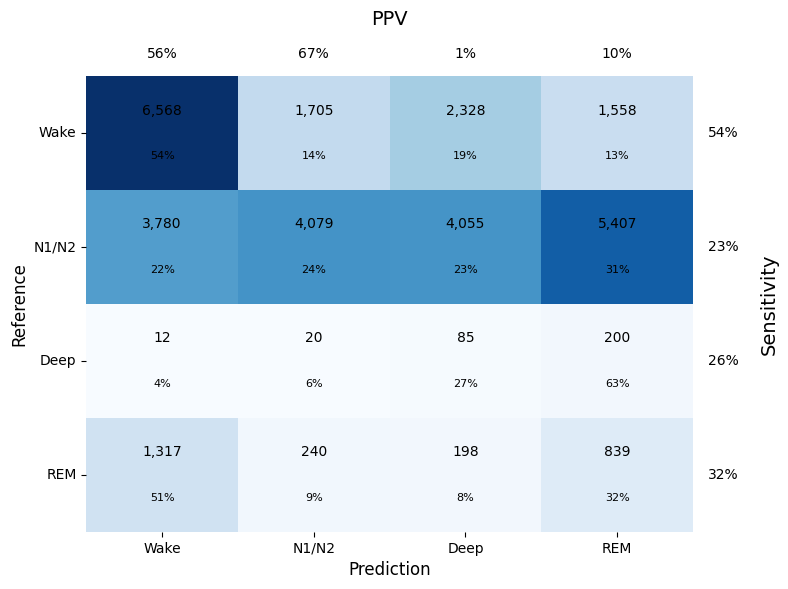

Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/ManualGRU/cms/cm_model9.png
Done with loop 9


In [17]:
accs = []
kappas = []
aurocs = []
cms = []
train_times = []
test_times = []
for i in range(10):
    model, train_time = train_model(
        batch_size = batch_size,
        dropout_embed = dropout_embed,
        acc_preprocess = acc_preprocess,
        RNN_type = RNN_type,
        lr = lr,
        rnn_hidden_size = rnn_hidden_size,
        pre_rnn_size = pre_rnn_size,
        hidden_size2 = hidden_size2,
        dropout_rnn = dropout_rnn,
        dropout_hidden2 = dropout_hidden2,
        modelType = modelType,
        nameAppend = f"model{i}")
    print(f"Trained model {i} in {train_time} seconds")
    acc, kappa, auroc, cm, inference_time_seconds = evaluate_model(model, test_loader, modelType, i)
    accs.append(acc)
    kappas.append(kappa)
    aurocs.append(auroc)
    cms.append(cms)
    train_times.append(train_time)
    test_times.append(inference_time_seconds)
    print(f"Done with loop {i}")

In [18]:
acc_mean, acc_std = np.mean(accs), np.std(accs)
kappa_mean, kappa_std = np.mean(kappas), np.std(kappas)
auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
train_time_mean, train_time_std = np.mean(train_times), np.std(train_times)
test_time_mean, test_time_std = np.mean(test_times), np.std(test_times)

# Print the statistics
print(f"Accuracy: Mean = {acc_mean:.3f}, StdDev = {acc_std:.3f}")
print(f"Kappa: Mean = {kappa_mean:.3f}, StdDev = {kappa_std:.3f}")
print(f"AUROC: Mean = {auroc_mean:.3f}, StdDev = {auroc_std:.3f}")

# Find the index of the best kappa
best_kappa_index = np.argmax(kappas)
print(f"Best Kappa Index: {best_kappa_index}")

# Find the index of the best acc
best_acc_index = np.argmax(accs)
print(f"Best Accuracy Index: {best_acc_index}")

# Find the index of the best AUROC
best_auroc_index = np.argmax(aurocs)
print(f"Best AUROC Index: {best_auroc_index}")

Accuracy: Mean = 0.380, StdDev = 0.035
Kappa: Mean = 0.152, StdDev = 0.026
AUROC: Mean = 0.615, StdDev = 0.034
Best Kappa Index: 4
Best Accuracy Index: 1
Best AUROC Index: 7
